<a href="https://colab.research.google.com/github/alfandoo/E-Commerce/blob/main/E_Commerce_Sales_Analysis%2C_Segmentation%2C_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

*  Explore Brazilian e-commerce sales data to understand sales trends, popular products, and market dynamics.
*  Analyze customer behavior and seller performance through segmentation and performance evaluation.
*  Identify logistics and delivery patterns to find factors that influence customer satisfaction.
*  Build forecasting models to project sales and support business decision-making.


# Library

In [78]:
%%capture
!pip install -U pip setuptools wheel cython
!pip install "numpy<2.0" "pandas<2.2" "scipy<1.13" "scikit-learn<1.4" "statsmodels<0.15"
!pip install "pmdarima==2.0.4"
!pip install geopandas
!pip install calmap

In [80]:
# Restart the kernel so that the C extension matches the newly installed NumPy header.
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import geopandas as gpd
import scipy.stats as stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu, kruskal
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import datetime
import random
import re
from itertools import cycle, product
import calmap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPython.display import display
from keras.layers import LSTM, Dense
from keras import Sequential
from keras.backend import clear_session
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from pmdarima.arima import ARIMA as pmdARIMA
from pmdarima.arima import ADFTest, KPSSTest, auto_arima
from pmdarima.utils import diff_inv
from scipy.special import boxcox1p, inv_boxcox1p
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL
from tensorflow.keras.optimizers import Adam

# Data Understanding

In [3]:
DATA_DIR = "/content/"

# ===========================
# Load Data
# ===========================
def load_csv(name):
    path = os.path.join(DATA_DIR, name)
    return pd.read_csv(path, low_memory=False)

orders            = load_csv("olist_orders_dataset.csv")
order_items       = load_csv("olist_order_items_dataset.csv")
payments          = load_csv("olist_order_payments_dataset.csv")
customers         = load_csv("olist_customers_dataset.csv")
products          = load_csv("olist_products_dataset.csv")
sellers           = load_csv("olist_sellers_dataset.csv")
geolocation       = load_csv("olist_geolocation_dataset.csv")
reviews           = load_csv("olist_order_reviews_dataset.csv")
product_category  = load_csv("product_category_name_translation.csv")

In [35]:
# Quick peeks
print("=== Customers: Head ===")
display(customers.head())
print("\n=== Customers: Info ===")
display(customers.info())

=== Customers: Head ===


customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP


=== Customers: Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


None

Customers – quick notes (from inspection)
- No missing values → all columns show full non-null counts (~99,441 rows).
- Potential duplicates:
• `customer_id` may repeat (a customer can place multiple orders).
• `customer_unique_id` should represent unique customers → unique count < total rows.
- Categorical columns: `customer_id`, `customer_unique_id`, `customer_city`, `customer_state`.
- Numeric column: `customer_zip_code_prefix`.

In [37]:
print("=== Orders: Head ===")
display(orders.head())

print("\n=== Orders: Info ===")
display(orders.info())

print("\n=== Orders: Order Status Counts ===")
display(orders["order_status"].value_counts())


=== Orders: Head ===


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00


=== Orders: Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  object        
 5   order_delivered_carrier_date   97658 non-null  object        
 6   order_delivered_customer_date  96476 non-null  object        
 7   order_estimated_delivery_date  99441 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 6.1+ MB


None


=== Orders: Order Status Counts ===


order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

Orders – quick notes
1) Missing values
   - `order_approved_at`: ~160 missing
   - `order_delivered_carrier_date`: ~1,783 missing
   - `order_delivered_customer_date`: ~2,965 missing
   → Expected for cancelled / undelivered orders.

2) Order status distribution
    - Dominated by **delivered** ≈ 96,478 (~97%)
    - Minor statuses such as `shipped`, `canceled`, `unavailable` total <3%
    - Rare statuses: `created` (5), `approved` (2) → possible noise.

3) Datetime format
    - All timestamp columns are strings (object); convert to datetime for duration/lag analysis.

In [38]:
print("=== Order Items: Head ===")
display(order_items.head())

print("\n=== Order Items: Info ===")
display(order_items.info())

print("\n=== Order Items: Unique Counts ===")
display(order_items.nunique())


=== Order Items: Head ===


order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14


=== Order Items: Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


None


=== Order Items: Unique Counts ===


order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

Order Items – quick notes
1) Uniques (`nunique`)
    - `order_id`: ~98,666 unique → many orders have multiple items (total rows ≈ 112,650).
    - `order_item_id`: max 21 → an order can include up to 21 items.
    - `product_id`: ~32,951 unique → high product variety.
    - `seller_id`: ~3,095 unique sellers.
    - `shipping_limit_date`: ~93,318 unique → wide spread of promised ship dates.
    - `price`: ~5,968 unique price points.
    - `freight_value`: ~6,999 unique freight values.

2) Relationships
    - Links **order → product → seller**.
    - Analysis ideas:
      • Best-selling products
      • Top sellers by volume/revenue
      • Average product price
      • Freight cost distribution

In [39]:
print("=== Payments: Head ===")
display(payments.head())

print("\n=== Payments: Unique Counts ===")
display(payments.nunique())

print("\n=== Payments: Info ===")
display(payments.info())

print("\n=== Payments: payment_value.describe() ===")
display(payments['payment_value'].describe())


=== Payments: Head ===


order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45


=== Payments: Unique Counts ===


order_id                99440
payment_sequential         29
payment_type                5
payment_installments       24
payment_value           29077
dtype: int64


=== Payments: Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


None


=== Payments: payment_value.describe() ===


count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64

 Payments – quick notes
1) Uniques
    - `order_id`: ~99,440 → aligns with unique orders in `orders`.
    - `payment_sequential`: up to 29 → some orders split into many payments.
    - `payment_type`: 5 types.
    - `payment_installments`: up to 24 installments.
    - `payment_value`: ~29,077 unique amounts.

2) `payment_value` distribution
    - Mean ≈ 154 BRL; Median = 100 BRL → **right-skewed**.
    - Some values are **0 BRL** → anomaly (voucher/test/refund).
    - Max ≈ 13,664 BRL → pricey items / outliers.


In [41]:
print("=== Reviews: Head ===")
display(reviews.head())

print("\n=== Reviews: Info ===")
display(reviews.info())

print("\n=== Reviews: Describe ===")
display(reviews.describe())


=== Reviews: Head ===


review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53


=== Reviews: Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


None


=== Reviews: Describe ===


review_score
count  99224.000000
mean       4.086421
std        1.347579
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000

Reviews – quick notes
1) Rating distribution (`review_score`)
    - Average ≈ **4.1** → customers generally satisfied.
    - Median = **5** → skewed positive; still some 1–2 star negatives.

2) Missing text
    - `review_comment_title`: ~11% filled.
    - `review_comment_message`: ~41% filled.
    → Many reviews are star-only, limiting text analysis.

3) Datetime
    - `review_creation_date` & `review_answer_timestamp` are strings → convert to datetime for trend analysis.

In [42]:
print("=== Products: Head ===")
display(products.head())

print("\n=== Products: Info ===")
display(products.info())

print("\n=== Products: Describe ===")
display(products.describe())

print("\n=== Products: Missing Values ===")
print(products.isnull().sum())

=== Products: Head ===


product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0


=== Products: Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


None


=== Products: Describe ===


product_name_lenght  product_description_lenght  product_photos_qty  \
count         32341.000000                32341.000000        32341.000000   
mean             48.476949                  771.495285            2.188986   
std              10.245741                  635.115225            1.736766   
min               5.000000                    4.000000            1.000000   
25%              42.000000                  339.000000            1.000000   
50%              51.000000                  595.000000            1.000000   
75%              57.000000                  972.000000            3.000000   
max              76.000000                 3992.000000           20.000000   

       product_weight_g  product_length_cm  product_height_cm  \
count      32949.000000       32949.000000       32949.000000   
mean        2276.472488          30.815078          16.937661   
std         4282.038731          16.914458          13.637554   
min            0.000000           7.000000           2.000000   
25%          300.000000          18.000000           8.000000   
50%          700.000000          25.000000          13.000000   
75%         1900.000000          38.000000          21.000000   
max        40425.000000         105.000000         105.000000   

       product_width_cm  
count      32949.000000  
mean          23.196728  
std           12.079047  
min            6.000000  
25%           15.000000  
50%           20.000000  
75%           30.000000  
max          118.000000


=== Products: Missing Values ===
product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64


Products – quick notes
1) Missing values
    - ~610 rows missing category/name_length/description_length/photo_qty (incomplete metadata).
    - ~2 rows missing physical attributes (weight/dimensions).

2) Numeric stats
    - Product name length: mean ≈ 48 chars; max 76.
    - Description length: mean ≈ 771 chars; max ~4000 (very long tails).
    - Photo count: median = 1; mean ≈ 2.2; up to 20 photos.
    - Weight (g):
      • Median: ~700 g
      • Mean: ~2,276 g → **skewed** by heavy outliers (up to ~40 kg)
      • Some weight = 0 → likely input errors
    - Dimensions (cm):
      • Median: 25 × 13 × 20
      • Very small values (e.g., 2 cm) → likely errors
      • Max height/width > 100 cm → large products (e.g., furniture)

In [43]:
print("=== Product Category: Head ===")
display(product_category.head())

print("\n=== Product Category: Info ===")
display(product_category.info())

print("\n=== Product Category: Describe ===")
display(product_category.describe())

=== Product Category: Head ===


product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor


=== Product Category: Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


None


=== Product Category: Describe ===


product_category_name product_category_name_english
count                     71                            71
unique                    71                            71
top             beleza_saude                 health_beauty
freq                       1                             1

Product Category Translation – quick notes
 - Lookup table mapping Portuguese → English category names.
   e.g., `beleza_saude` → `health_beauty`.
 - Typically joined to `products.product_category_name` for analysis/readability.
 - Because ~610 product categories are missing in `products`, post-join NaNs will remain
   → consider leaving as NaN or label as "unknown".

In [44]:
print("=== Sellers: Head ===")
display(sellers.head())

print("\n=== Sellers: Info ===")
display(sellers.info())

print("\n=== Sellers: Seller State Counts ===")
display(sellers["seller_state"].value_counts())


=== Sellers: Head ===


seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3          sao paulo           SP  
4  braganca paulista           SP


=== Sellers: Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


None


=== Sellers: Seller State Counts ===


seller_state
SP    1849
PR     349
MG     244
SC     190
RJ     171
RS     129
GO      40
DF      30
ES      23
BA      19
CE      13
PE       9
PB       6
RN       5
MS       5
MT       4
RO       2
SE       2
PI       1
AC       1
MA       1
AM       1
PA       1
Name: count, dtype: int64

Sellers – quick notes
1) Sellers per state (`seller_state`)
    - SP (São Paulo) ≈ 1,849 sellers (~60% of total)
    - PR: ~349, MG: ~244, SC: ~190, RJ: ~171
    → Top 5 states (SP, PR, MG, SC, RJ) dominate the supply side.

2) Small states
    - Some states have only 1–2 sellers (e.g., AC, PI, MA, AM, PA)
    - Seller distribution is **uneven**, concentrated in the south/southeast.

3) Further analysis
    - Geographic distribution of sellers vs. customers → shipping implications (cost/delay).
    - Seller productivity → join with `order_items` to compute units sold per seller.
    - Revenue contribution by seller state.

In [45]:
# Aggregate by ZIP prefix to get mean coordinates and representative city/state
geolocation = (
    geolocation
    .groupby("geolocation_zip_code_prefix")
    .agg(
        geolocation_lat   = ("geolocation_lat", "mean"),
        geolocation_lng   = ("geolocation_lng", "mean"),
        geolocation_city  = ("geolocation_city", "first"),
        geolocation_state = ("geolocation_state", "first"),
    )
    .reset_index()
)

print("=== Geolocation: Info ===")
display(geolocation.info())

print("\n=== Geolocation: Unique States ===")
display(geolocation["geolocation_state"].unique())


=== Geolocation: Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19015 entries, 0 to 19014
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   geolocation_zip_code_prefix  19015 non-null  int64  
 1   geolocation_lat              19015 non-null  float64
 2   geolocation_lng              19015 non-null  float64
 3   geolocation_city             19015 non-null  object 
 4   geolocation_state            19015 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 742.9+ KB


None


=== Geolocation: Unique States ===


array(['SP', 'RJ', 'ES', 'MG', 'BA', 'SE', 'PE', 'RN', 'AL', 'PB', 'CE',
       'PI', 'MA', 'PA', 'AP', 'AM', 'RR', 'AC', 'DF', 'GO', 'RO', 'TO',
       'MT', 'MS', 'PR', 'SC', 'RS'], dtype=object)

Geolocation – quick notes
1) State coverage
    - 27 Brazilian states (SP, RJ, MG, RS, etc.) → nationally representative coverage.

2) Granularity
    - Only ZIP code prefixes (not full addresses).
    - Coordinates enable:
      • Heatmaps of customer/seller distribution
      • Distance analysis (seller ↔ customer)
      • Freight estimation (correlates with `freight_value` in `order_items`)

3) Joins
    - `geolocation_zip_code_prefix` joins to:
      • `customer_zip_code_prefix` (in **customers**)
      • `seller_zip_code_prefix` (in **sellers**)
    - Useful for geographic mapping of customers and sellers.

📊 Dataset Summary & Key Observations (Olist Brazilian E-Commerce)

---

1. Customers  
- **Rows**: ~99,441  
- **Key fields**: `customer_id`, `customer_unique_id`, `customer_zip_code_prefix`, `customer_city`, `customer_state`  
- **Notes**:  
  • `customer_id` may repeat (one customer can place multiple orders)  
  • `customer_unique_id` ≈ true unique customers  
  • No missing values  
  • Customers concentrated in **São Paulo (SP)**  

---

2. Orders  
- **Rows**: ~99,441  
- **Highlights**:  
  • ~97% are **delivered**  
  • Small shares of `canceled` / `unavailable`  
  • Timestamp columns need **datetime conversion**  
  • Missing timestamps expected for failed/canceled orders  

---

3. Order Items  
- **Rows**: ~112,650  
- **Highlights**:  
  • Up to **21 items** per order  
  • ~32,951 unique products, ~3,095 unique sellers  
  • Rich variation in `price` and `freight_value`  

---

4. Payments  
- **Rows**: ~103,886  
- **Highlights**:  
  • 5 payment types (mostly **credit_card**)  
  • Installments up to **24x**  
  • `payment_value` is **right-skewed**  
  • Some anomalies: **0 BRL payments**  

---

5. Reviews  
- **Rows**: ~99,224  
- **Highlights**:  
  • Average score ≈ **4.1** (median = 5) → mostly positive  
  • Negative tail exists (scores **1–2**)  
  • Limited text reviews (~40% messages, ~11% titles)  

---

6. Products  
- **Rows**: ~32,951  
- **Highlights**:  
  • 610 rows missing category/metadata  
  • Weight distribution skewed (0 g → 40 kg) → anomalies  
  • Dimension outliers; typical product: **700 g, 25×13×20 cm**  

---

7. Product Category Translation  
- **Rows**: 71  
- **Highlights**:  
  • Dictionary to map Portuguese → English  
  • Keep `"unknown"` label for unmapped categories  

---

8. Sellers  
- **Rows**: ~3,095  
- **Highlights**:  
  • ~60% of sellers located in **São Paulo (SP)**  
  • Long tail of states with only 1–2 sellers  
  • Strong geographic concentration  

---

9. Geolocation  
- **Rows**: ~19,015 (ZIP prefixes)  
- **Highlights**:  
  • Covers **27 Brazilian states** (nationally representative)  
  • Useful for mapping customers & sellers  
  • Enables distance-based logistics and freight analysis  

---


# 🧼 Data Cleaning

In [12]:
# -----------------------------
# Orders: convert timestamps
# -----------------------------
ORDER_TIME_COLS = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]

for col in ORDER_TIME_COLS:
    if col in orders.columns:
        orders[col] = pd.to_datetime(orders[col], errors="coerce")

In [46]:
# -----------------------------
# Orders: remove impossible timelines
# (keep canceled/undelivered, drop logically impossible rows)
# -----------------------------
invalid_orders = orders[
    (orders["order_approved_at"] < orders["order_purchase_timestamp"]) |
    (orders["order_delivered_carrier_date"] < orders["order_approved_at"]) |
    (orders["order_delivered_customer_date"] < orders["order_delivered_carrier_date"]) |
    (orders["order_estimated_delivery_date"] < orders["order_purchase_timestamp"])
].copy()

print("=== Invalid Orders: Initial Info ===")
buf = io.StringIO()
invalid_orders["order_delivered_customer_date"].info(buf=buf)
print(buf.getvalue())

# Remove invalid rows with non-null delivered timestamps
null_orders = invalid_orders[invalid_orders["order_delivered_customer_date"].isnull()]
invalid_orders = invalid_orders.drop(null_orders.index)

print("\n=== Invalid Orders: After Cleaning ===")
buf = io.StringIO()
invalid_orders.info(buf=buf)
print(buf.getvalue())

print(f"\nKept null-delivered orders (for inspection): {len(null_orders)}")
print(f"Removed invalid orders with timestamps: {len(invalid_orders)}")

=== Invalid Orders: Initial Info ===
<class 'pandas.core.series.Series'>
Index: 1382 entries, 15 to 99406
Series name: order_delivered_customer_date
Non-Null Count  Dtype 
--------------  ----- 
1373 non-null   object
dtypes: object(1)
memory usage: 21.6+ KB


=== Invalid Orders: After Cleaning ===
<class 'pandas.core.frame.DataFrame'>
Index: 1373 entries, 15 to 99406
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       1373 non-null   object        
 1   customer_id                    1373 non-null   object        
 2   order_status                   1373 non-null   object        
 3   order_purchase_timestamp       1373 non-null   datetime64[ns]
 4   order_approved_at              1373 non-null   object        
 5   order_delivered_carrier_date   1373 non-null   object        
 6   order_delivered_customer_date  1373 non-null   object   

In [47]:
# -----------------------------
# Drop invalid orders from master
# -----------------------------
orders = orders.drop(invalid_orders.index).reset_index(drop=True)

print("=== Orders: After Removing Invalid Rows ===")
buf = io.StringIO()
orders.info(buf=buf)
print(buf.getvalue())
print(f"\nTotal rows after cleaning: {len(orders):,}")


=== Orders: After Removing Invalid Rows ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98068 entries, 0 to 98067
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98068 non-null  object        
 1   customer_id                    98068 non-null  object        
 2   order_status                   98068 non-null  object        
 3   order_purchase_timestamp       98068 non-null  datetime64[ns]
 4   order_approved_at              97908 non-null  object        
 5   order_delivered_carrier_date   96285 non-null  object        
 6   order_delivered_customer_date  95103 non-null  object        
 7   order_estimated_delivery_date  98068 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 6.0+ MB


Total rows after cleaning: 98,068


 🧹 Data Cleaning – Orders (Notes)
 - All order timestamps converted to datetime.
 - Logically impossible shipping sequences removed.
 - Canceled/undelivered orders retained (only impossible sequences dropped).
 - Index reset after cleaning.


In [48]:
# -----------------------------
# Order Items: basic rules
# -----------------------------
print("=== Order Items: Initial Shape ===")
print(f"Rows: {order_items.shape[0]:,}\n")

# Keep strictly positive price; non-negative freight
order_items = order_items.loc[order_items["price"] > 0].copy()
order_items = order_items.loc[order_items["freight_value"] >= 0].copy()

# Rename + convert to datetime
if "shipping_limit_date" in order_items.columns:
    order_items = order_items.rename(columns={"shipping_limit_date": "shipping_deadline"})
    order_items["shipping_deadline"] = pd.to_datetime(order_items["shipping_deadline"], errors="coerce")

print("=== Order Items: After Cleaning ===")
buf = io.StringIO()
order_items.info(buf=buf)
print(buf.getvalue())
print(f"\nTotal rows after cleaning: {len(order_items):,}")


=== Order Items: Initial Shape ===
Rows: 112,650

=== Order Items: After Cleaning ===
<class 'pandas.core.frame.DataFrame'>
Index: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   order_id           112650 non-null  object        
 1   order_item_id      112650 non-null  int64         
 2   product_id         112650 non-null  object        
 3   seller_id          112650 non-null  object        
 4   shipping_deadline  112650 non-null  datetime64[ns]
 5   price              112650 non-null  float64       
 6   freight_value      112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.9+ MB


Total rows after cleaning: 112,650


 🧹 Data Cleaning – Order Items (Notes)
 - Removed rows with non-positive price or negative freight.
 - Converted `shipping_deadline` to datetime (renamed from `shipping_limit_date`).

In [49]:
# -----------------------------
# Payments: normalize, remove "not_defined"
# -----------------------------
payments = payments.copy()

# Normalisasi label
payments["payment_type"] = payments["payment_type"].replace("boleto", "bank_slip")

# Opsional: drop baris dengan payment_type "not_defined"
payments = payments[payments["payment_type"] != "not_defined"].copy()

print("=== Payments: Value Counts (Normalized) ===")
print(payments["payment_type"].value_counts())
print("\n=== Payments: Unique Types ===")
print(payments["payment_type"].unique())
print(f"\nTotal rows: {len(payments):,}")


=== Payments: Value Counts (Normalized) ===
payment_type
credit_card    76795
bank_slip      19784
voucher         5775
debit_card      1529
Name: count, dtype: int64

=== Payments: Unique Types ===
['credit_card' 'bank_slip' 'voucher' 'debit_card']

Total rows: 103,883


In [17]:
# Orders with undefined payment type (typically canceled/not approved)
unknown_pay_order_ids = payments.loc[payments["payment_type"] == "not_defined", "order_id"].tolist()
unknown_orders = orders[orders["order_id"].isin(unknown_pay_order_ids)]
print(unknown_orders.shape[0])

3


In [18]:
# EDA excludes canceled/undefined payments
order_payments = payments[payments["payment_type"] != "not_defined"].copy()
orders = orders[~orders["order_id"].isin(unknown_pay_order_ids)].copy()
_ = order_payments.shape[0]

 🧹 Data Cleaning – Order Payments (Notes)
 - Standardized payment type names (`boleto` -> `bank_slip`).
 - Dropped `not_defined` payments (canceled/not approved), and corresponding orders for EDA focus.

In [50]:
# -----------------------------
# Reviews: timestamps, duplicates, suspicious links
# -----------------------------
REVIEW_TIME_COLS = ["review_creation_date", "review_answer_timestamp"]
for col in REVIEW_TIME_COLS:
    if col in reviews.columns:
        reviews[col] = pd.to_datetime(reviews[col], errors="coerce")

print("=== Reviews: Missing Review IDs ===")
print(reviews["review_id"].isnull().sum())

print("\n=== Reviews: Info ===")
print(reviews.info())

print("\n=== Reviews: Duplicate order_id check ===")
dup_orders = reviews[reviews["order_id"].duplicated()]
print(f"Found {dup_orders.shape[0]} duplicate order_id(s)")
display(dup_orders.head())


=== Reviews: Missing Review IDs ===
0

=== Reviews: Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                99224 non-null  object        
 1   order_id                 99224 non-null  object        
 2   review_score             99224 non-null  int64         
 3   review_comment_title     11568 non-null  object        
 4   review_comment_message   40977 non-null  object        
 5   review_creation_date     99224 non-null  datetime64[ns]
 6   review_answer_timestamp  99224 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 5.3+ MB
None

=== Reviews: Duplicate order_id check ===
Found 551 duplicate order_id(s)


review_id                          order_id  \
1119  46abf3ea0b2710ad41390fdb79c32d84  5040757d4e06a4be96d3827b860b4e7c   
3109  aa193e76d35950c4ae988237bb36ed2b  cf73e2cb1f4a9480ed70c154da3d954a   
8108  40294ea5a778dc62080d6b3f55d361ce  e1bc1083cd7acd30d0576335373b907d   
9064  32e2c7e889f7a185d462265398ee3631  c7cfea0c153e6382e32e84c2a9dd7d2e   
9795  95a3135743556b117d888cc8c6e12e11  f9c78e6e58306dc81efbbada1ac11f24   

      review_score review_comment_title  \
1119             5                  NaN   
3109             5                  NaN   
8108             5                  NaN   
9064             5                  NaN   
9795             3                  NaN   

                                 review_comment_message review_creation_date  \
1119                                                NaN           2017-11-07   
3109                                                NaN           2018-01-18   
8108                                                NaN           2018-03-23   
9064                                                NaN           2017-10-21   
9795  O produto chegou antes do prazo mas recebi um ...           2017-09-14   

     review_answer_timestamp  
1119     2017-11-10 20:07:48  
3109     2018-01-18 17:36:45  
8108     2018-03-24 00:23:06  
9064     2017-10-22 00:47:25  
9795     2017-09-17 11:14:08

In [20]:
# Check unusual multi-linking by review_id
_ = (
    reviews.groupby("review_id")
    .agg(order_id=("order_id", "nunique"), review_score=("review_score", "nunique"),
         review_creation_date=("review_creation_date", "nunique"))
    .sort_values(by="order_id", ascending=False)
)

# Example suspicious case (kept from your original logic)
fake_reviews = reviews[reviews["review_id"] == "ddc52555ca27b0fe67d5255147682d2d"]
fake_order_ids = fake_reviews["order_id"]
fake_customers = orders.loc[orders["order_id"].isin(fake_order_ids), "customer_id"]
_ = customers[customers["customer_id"].isin(fake_customers)]

# Drop duplicated review_ids (keep first)
before = reviews.shape[0]
order_reviews = reviews.drop_duplicates(subset=["review_id"], keep="first").copy()
after = order_reviews.shape[0]

print(f"Reviews before cleaning: {before}")
print(f"Removed {before - after} duplicate/fake reviews")
print(f"Remaining: {after}")

Reviews before cleaning: 99224
Removed 814 duplicate/fake reviews
Remaining: 98410


 🧹 Data Cleaning – Order Reviews (Notes)
 - Converted review timestamps to datetime.
 - Checked for missing/duplicate review IDs.
 - Flagged potential many-to-many anomalies; dropped duplicate `review_id`s to prevent bias.

In [51]:
# -----------------------------
# Products: fix typos, handle missing/invalid
# -----------------------------
products = products.copy()

# Fix column typos
products = products.rename(
    columns={
        "product_name_lenght": "product_name_length",
        "product_description_lenght": "product_description_length",
    }
)

# Missing categories
missing_ratio = products["product_category_name"].isna().mean() * 100
print("=== Products: Missing Category Info ===")
print(f"Missing categories: {missing_ratio:.2f}%")

# Drop rows with missing category
products = products.dropna(subset=["product_category_name"]).copy()

print("\n=== Products: Info After Cleaning ===")
print(products.info())

=== Products: Missing Category Info ===
Missing categories: 1.85%

=== Products: Info After Cleaning ===
<class 'pandas.core.frame.DataFrame'>
Index: 32341 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32341 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_length         32341 non-null  float64
 3   product_description_length  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32340 non-null  float64
 6   product_length_cm           32340 non-null  float64
 7   product_height_cm           32340 non-null  float64
 8   product_width_cm            32340 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.5+ MB
None


In [52]:
# -----------------------------
# Products: Physical attributes cleanup
# -----------------------------
phys_cols = ["product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"]

# Median imputation
for col in phys_cols:
    if col in products.columns:
        median_val = products[col].median()
        products[col] = products[col].fillna(median_val)

# Remove non-positive attributes
products = products.loc[products["product_weight_g"] > 0].copy()
products = products.loc[
    (products["product_length_cm"] > 0) &
    (products["product_height_cm"] > 0) &
    (products["product_width_cm"]  > 0)
].copy()

print("=== Products: Info After Physical Cleanup ===")
print(products.info())

print("\n=== Products: Unique Counts ===")
print(products.nunique())

product_names_pt = products["product_category_name"].unique()
print("\n=== Sample Category Names (PT) ===")
print(product_names_pt[:10])

=== Products: Info After Physical Cleanup ===
<class 'pandas.core.frame.DataFrame'>
Index: 32337 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32337 non-null  object 
 1   product_category_name       32337 non-null  object 
 2   product_name_length         32337 non-null  float64
 3   product_description_length  32337 non-null  float64
 4   product_photos_qty          32337 non-null  float64
 5   product_weight_g            32337 non-null  float64
 6   product_length_cm           32337 non-null  float64
 7   product_height_cm           32337 non-null  float64
 8   product_width_cm            32337 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.5+ MB
None

=== Products: Unique Counts ===
product_id                    32337
product_category_name            73
product_name_length              66
product_description_length

 🧹 Data Cleaning – Products (Notes)
 - Fixed misspelled column names.
 - Removed rows with missing product category.
 - Median-filled weight/dimensions; removed non-positive values.
 - Saved unique PT category names for later mapping.

In [53]:
# -----------------------------
# Category translation: ensure coverage
# -----------------------------
print("=== Product Category: Info ===")
print(product_category.info())

product_names_eng = product_category["product_category_name"].unique()

missing_names = set(product_names_pt) - set(product_category["product_category_name"])
print("\n=== Missing Categories (PT not in translation table) ===")
print(missing_names)

if missing_names:
    print(f"\nTotal missing: {len(missing_names)}")
    missing_names_df = products[products["product_category_name"].isin(missing_names)]
    print("\n=== Sample Products with Missing Categories ===")
    display(missing_names_df.head())

new_rows = pd.DataFrame({
    "product_category_name": [
        "portateis_cozinha_e_preparadores_de_alimentos",
        "pc_gamer"
    ],
    "product_category_name_english": [
        "portable_kitchen_and_food_preparers",
        "pc_gamer"
    ],
})

product_category = (
    pd.concat([product_category, new_rows], ignore_index=True)
    .drop_duplicates(subset=["product_category_name"])
    .reset_index(drop=True)
)

print("\n=== Final Product Category Shape ===")
print(product_category.shape)


=== Product Category: Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB
None

=== Missing Categories (PT not in translation table) ===
{'portateis_cozinha_e_preparadores_de_alimentos', 'pc_gamer'}

Total missing: 2

=== Sample Products with Missing Categories ===


product_id  \
1628  0105b5323d24fc655f73052694dbbb3a   
5821  6fd83eb3e0799b775e4f946bd66657c0   
7325  5d923ead886c44b86845f69e50520c3e   
7478  6727051471a0fc4a0e7737b57bff2549   
8819  bed164d9d628cf0593003389c535c6e0   

                              product_category_name  product_name_length  \
1628                                       pc_gamer                 59.0   
5821  portateis_cozinha_e_preparadores_de_alimentos                 52.0   
7325  portateis_cozinha_e_preparadores_de_alimentos                 58.0   
7478                                       pc_gamer                 60.0   
8819  portateis_cozinha_e_preparadores_de_alimentos                 54.0   

      product_description_length  product_photos_qty  product_weight_g  \
1628                       621.0                 4.0            2839.0   
5821                       280.0                 1.0            1200.0   
7325                       284.0                 1.0            1200.0   
7478                      1532.0                 3.0             650.0   
8819                       382.0                 2.0             850.0   

      product_length_cm  product_height_cm  product_width_cm  
1628               19.0               16.0              18.0  
5821               25.0               33.0              25.0  
7325               25.0               33.0              25.0  
7478               16.0               22.0              20.0  
8819               30.0               21.0              22.0


=== Final Product Category Shape ===
(73, 2)


 🧹 Data Cleaning – Product Category Translation (Notes)
 - Compared PT categories against the EN translation table.
 - Added missing translations manually.
 - Ensured no duplicate category keys remain.

In [55]:
# -----------------------------
# Sellers: normalize city names
# -----------------------------
import unicodedata

def strip_accents(text: str) -> str:
    """Remove accents/diacritics from the text."""
    s = unicodedata.normalize("NFKD", str(text))
    return "".join(c for c in s if not unicodedata.combining(c))

print("=== Sellers: Info ===")
print(sellers.info())

print("\n=== Data Quality Checks ===")
print("Null seller_id:", sellers["seller_id"].isnull().sum())
print("Duplicated seller_id:", sellers["seller_id"].duplicated().sum())

dupe_sellers = sellers[sellers["seller_id"].duplicated(keep=False)]
if not dupe_sellers.empty:
    print("\n=== Duplicate seller_id rows ===")
    display(dupe_sellers.head())

# Normalize city names
sellers = sellers.copy()
sellers["seller_city"] = (
    sellers["seller_city"]
    .astype(str)
    .str.lower()
    .str.strip()
    .map(strip_accents)
)

print("\n=== After Normalization ===")
print("Duplicated seller_city:", sellers["seller_city"].duplicated().sum())
print("Unique seller_city:", sellers["seller_city"].nunique())


=== Sellers: Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
None

=== Data Quality Checks ===
Null seller_id: 0
Duplicated seller_id: 0

=== After Normalization ===
Duplicated seller_city: 2486
Unique seller_city: 609


In [25]:
# Inspect singleton cities (optional)
single_entry_cities = sellers["seller_city"].value_counts()
single_entry_cities = single_entry_cities[single_entry_cities == 1]
_ = sorted(single_entry_cities.index)

# Fix common typos/variants
city_rename = {
    "rio de janeiro": "rio de janeiro",
    "sao miguel": "sao miguel d'oeste",
    "sao pau": "sao paulo",
}
for wrong, correct in city_rename.items():
    mask = sellers["seller_city"].str.contains(wrong, case=False, na=False)
    sellers.loc[mask, "seller_city"] = correct

print(sellers["seller_state"].value_counts())

seller_state
SP    1849
PR     349
MG     244
SC     190
RJ     171
RS     129
GO      40
DF      30
ES      23
BA      19
CE      13
PE       9
PB       6
MS       5
RN       5
MT       4
RO       2
SE       2
AC       1
PI       1
MA       1
AM       1
PA       1
Name: count, dtype: int64


 🧹 Data Cleaning – Sellers (Notes)
 - Verified `seller_id` nulls/duplicates (none expected).
 - Normalized city names: lowercased, trimmed, accent-stripped.
 - Fixed common typos via manual mapping.
 - Checked `seller_state` distribution for anomalies.

# 🔧 Wrangle the Data

With the datasets cleaned and standardized, we now:
 - Reshape if needed (pivot/melt),
 - Merge the core tables (orders, items, customers, sellers, products, etc.),
 - Filter/aggregate/group to build features and answer business questions.
 This ensures a unified, analysis-ready table for deeper EDA and modeling.

In [26]:
# ---------------------------
# 1) Customers + Geolocation
# ---------------------------
customers_geo = (
    customers.merge(
        geolocation,
        how="left",
        left_on="customer_zip_code_prefix",
        right_on="geolocation_zip_code_prefix",
    )
    .sort_values(by="customer_zip_code_prefix")
    .ffill()  # forward-fill gaps after sorting
)
print("customers_geo shape:", customers_geo.shape)
display(customers_geo.head())

customers_geo shape: (99441, 10)


customer_id                customer_unique_id  \
23914  7ae2a9337aa4bc799723511faa1d6830  0c1a20644f0dc126c3eaff8dbc1bd12c   
23990  ee9b73e88afb4904ee2322cfc89cf638  095e7c124c5c1ccb1eb9f731152eae6a   
11747  a09edf8c1e842e94805a206b3d73eed5  968f6d2f674977d88a4b445a5117ccd8   
81634  15d7dbcd027b5b24866db33e2b819021  ddab5650ba76e2fa2d7e25ed3343bd92   
92799  6e4eb34e7f4d526a82726712aa17c02b  ded4351942c7fc292b88e5b090af2b46   

       customer_zip_code_prefix customer_city customer_state  \
23914                      1003     sao paulo             SP   
23990                      1004     sao paulo             SP   
11747                      1004     sao paulo             SP   
81634                      1005     sao paulo             SP   
92799                      1005     sao paulo             SP   

       geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
23914                       1003.0       -23.548994       -46.635731   
23990                       1004.0       -23.549799       -46.634757   
11747                       1004.0       -23.549799       -46.634757   
81634                       1005.0       -23.549456       -46.636733   
92799                       1005.0       -23.549456       -46.636733   

      geolocation_city geolocation_state  
23914        sao paulo                SP  
23990        sao paulo                SP  
11747        sao paulo                SP  
81634        sao paulo                SP  
92799        sao paulo                SP

In [27]:
# ---------------------------
# 2) Orders + Items + Payments + Reviews + Products + Categories + Sellers
# ---------------------------
orders_all = (
    orders
      .merge(order_items,       how="left", on="order_id", validate="1:m")
      .merge(order_payments,    how="left", on="order_id")
      .merge(order_reviews,     how="left", on="order_id")
      .merge(products,          how="left", on="product_id")
      .merge(product_category,  how="left", on="product_category_name")
      .merge(sellers,           how="left", on="seller_id")
)
print("orders_all shape:", orders_all.shape)
display(orders_all.head())

orders_all shape: (117110, 36)


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  order_item_id  \
0                    2017-10-18            1.0   
1                    2017-10-18            1.0   
2                    2017-10-18            1.0   
3                    2018-08-13            1.0   
4                    2018-09-04            1.0   

                         product_id  ... product_description_length  \
0  87285b34884572647811a353c7ac498a  ...                      268.0   
1  87285b34884572647811a353c7ac498a  ...                      268.0   
2  87285b34884572647811a353c7ac498a  ...                      268.0   
3  595fac2a385ac33a80bd5114aec74eb8  ...                      178.0   
4  aa4383b373c6aca5d8797843e5594415  ...                      232.0   

  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  \
0                4.0             500.0               19.0                8.0   
1                4.0             500.0               19.0                8.0   
2                4.0             500.0               19.0                8.0   
3                1.0             400.0               19.0               13.0   
4                1.0             420.0               24.0               19.0   

  product_width_cm  product_category_name_english  seller_zip_code_prefix  \
0             13.0                     housewares                  9350.0   
1             13.0                     housewares                  9350.0   
2             13.0                     housewares                  9350.0   
3             19.0                      perfumery                 31570.0   
4             21.0                           auto                 14840.0   

      seller_city  seller_state  
0            maua            SP  
1            maua            SP  
2            maua            SP  
3  belo horizonte            SP  
4         guariba            SP  

[5 rows x 36 columns]

In [28]:
# ---------------------------
# 3) Final unified dataset
# ---------------------------
commerce = customers.merge(orders_all, how="inner", on="customer_id")
print("\nFinal commerce shape:", commerce.shape)
display(commerce.head())
display(commerce.info())


Final commerce shape: (117110, 40)


customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

    order_approved_at order_delivered_carrier_date  ...  \
0 2017-05-16 15:22:12          2017-05-23 10:47:57  ...   
1 2018-01-12 20:58:32          2018-01-15 17:14:59  ...   
2 2018-05-20 16:19:10          2018-06-11 14:31:00  ...   
3 2018-03-13 17:29:19          2018-03-27 23:22:42  ...   
4 2018-07-29 10:10:09          2018-07-30 15:16:00  ...   

  product_description_length product_photos_qty  product_weight_g  \
0                     1141.0                1.0            8683.0   
1                     1002.0                3.0           10150.0   
2                      955.0                1.0            8267.0   
3                     1066.0                1.0           12160.0   
4                      407.0                1.0            5200.0   

  product_length_cm product_height_cm product_width_cm  \
0              54.0              64.0             31.0   
1              89.0              15.0             40.0   
2              52.0              52.0             17.0   
3              56.0              51.0             28.0   
4              45.0              15.0             35.0   

   product_category_name_english  seller_zip_code_prefix      seller_city  \
0               office_furniture                  8577.0  itaquaquecetuba   
1                     housewares                 88303.0           itajai   
2               office_furniture                  8577.0  itaquaquecetuba   
3               office_furniture                  8577.0  itaquaquecetuba   
4                   home_confort                 14940.0         ibitinga   

  seller_state  
0           SP  
1           SC  
2           SP  
3           SP  
4           SP  

[5 rows x 40 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117110 entries, 0 to 117109
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    117110 non-null  object        
 1   customer_unique_id             117110 non-null  object        
 2   customer_zip_code_prefix       117110 non-null  int64         
 3   customer_city                  117110 non-null  object        
 4   customer_state                 117110 non-null  object        
 5   order_id                       117110 non-null  object        
 6   order_status                   117110 non-null  object        
 7   order_purchase_timestamp       117110 non-null  datetime64[ns]
 8   order_approved_at              116937 non-null  datetime64[ns]
 9   order_delivered_carrier_date   115038 non-null  datetime64[ns]
 10  order_delivered_customer_date  113710 non-null  datetime64[ns]
 11  

None

In [29]:
# ---------------------------
# 4) Quality & consistency checks
# ---------------------------

# Duplicates
dup_count = commerce.duplicated().sum()
print("\nDuplicate rows:", dup_count)

# Nulls (top offenders)
null_summary = commerce.isnull().sum().sort_values(ascending=False)
print("\nColumns with missing values (nonzero only):")
print(null_summary[null_summary > 0].head(20))

# Row consistency
print("\nOrders before merge:", orders.shape[0])
print("Orders after merge (non-null status):", commerce["order_status"].notna().sum())

print("Unique customers before merge:", customers["customer_unique_id"].nunique())
print("Unique customers after merge:", commerce["customer_unique_id"].nunique())

# Sanity checks on key fields
print("\nUnique sellers:", commerce["seller_id"].nunique())
print("Unique product categories (EN):", commerce["product_category_name_english"].nunique())
print("Unique payment types:", commerce["payment_type"].nunique())


Duplicate rows: 0

Columns with missing values (nonzero only):
review_comment_title             103699
review_comment_message            67931
order_delivered_customer_date      3400
product_description_length         2532
product_length_cm                  2532
product_photos_qty                 2532
product_height_cm                  2532
product_category_name              2532
product_weight_g                   2532
product_name_length                2532
product_width_cm                   2532
product_category_name_english      2532
order_delivered_carrier_date       2072
review_answer_timestamp            1587
review_score                       1587
review_id                          1587
review_creation_date               1587
product_id                          827
shipping_deadline                   827
seller_id                           827
dtype: int64

Orders before merge: 98065
Orders after merge (non-null status): 117110
Unique customers before merge: 96096
Unique custom

In [30]:
# ---------------------------
# 5) Descriptive statistics
# ---------------------------
num_desc = commerce.describe(include=[np.number]).T
display(num_desc)

# ---------------------------
# 6) Categorical distributions (top 5)
# ---------------------------
for col in ["order_status", "payment_type", "product_category_name_english"]:
    print(f"\nTop values for {col}:")
    print(commerce[col].value_counts().head())

count          mean           std      min  \
customer_zip_code_prefix    117110.0  35009.772129  29803.792850  1004.00   
order_item_id               116283.0      1.196254      0.700369     1.00   
price                       116283.0    120.872841    184.698813     0.85   
freight_value               116283.0     20.030460     15.857656     0.00   
payment_sequential          117107.0      1.094913      0.732757     1.00   
payment_installments        117107.0      2.941208      2.778184     0.00   
payment_value               117107.0    172.985415    269.002904     0.00   
review_score                115523.0      4.015720      1.400174     1.00   
product_name_length         114578.0     48.759378     10.032276     5.00   
product_description_length  114578.0    786.424890    652.941356     4.00   
product_photos_qty          114578.0      2.205144      1.718295     1.00   
product_weight_g            114578.0   2122.888085   3796.585964     2.00   
product_length_cm           114578.0     30.336784     16.235017     7.00   
product_height_cm           114578.0     16.668191     13.493156     2.00   
product_width_cm            114578.0     23.122022     11.762974     6.00   
seller_zip_code_prefix      116283.0  24437.428154  27560.404705  1001.00   

                                 25%       50%       75%       max  
customer_zip_code_prefix    11250.00  24240.00  58415.75  99990.00  
order_item_id                   1.00      1.00      1.00     21.00  
price                          39.90     74.90    134.90   6735.00  
freight_value                  13.08     16.27     21.18    409.68  
payment_sequential              1.00      1.00      1.00     29.00  
payment_installments            1.00      2.00      4.00     24.00  
payment_value                  60.85    108.12    189.19  13664.08  
review_score                    4.00      5.00      5.00      5.00  
product_name_length            42.00     52.00     57.00     76.00  
product_description_length    346.00    601.00    985.00   3992.00  
product_photos_qty              1.00      1.00      3.00     20.00  
product_weight_g              300.00    700.00   1800.00  40425.00  
product_length_cm              18.00     25.00     38.00    105.00  
product_height_cm               8.00     13.00     20.00    105.00  
product_width_cm               15.00     20.00     30.00    118.00  
seller_zip_code_prefix       6440.00  13660.00  27930.00  99730.00


Top values for order_status:
order_status
delivered      113711
shipped          1250
canceled          742
unavailable       650
processing        376
Name: count, dtype: int64

Top values for payment_type:
payment_type
credit_card    86342
bank_slip      22741
voucher         6368
debit_card      1656
Name: count, dtype: int64

Top values for product_category_name_english:
product_category_name_english
bed_bath_table           11731
health_beauty             9818
sports_leisure            8872
furniture_decor           8665
computers_accessories     8011
Name: count, dtype: int64


# 📊 Exploratory Data Analysis

Most Common Order Statuses  
- Question: What are the most common order statuses?  
- Viz: Bar chart of `order_status` distribution  
- Insight: Delivered dominates; minor statuses (canceled, unavailable, etc.) are small.  

Sales Trend Over Time  
- Question: How do sales trend over time?  
- Viz: Daily & monthly order counts from `order_purchase_timestamp`  
- Insight: Reveals growth/decline patterns and seasonality.  

Seasonality (Days / Months with Highest Sales)  
- Question: Which days of the week or months have the highest sales?  
- Viz: Bar/heatmap for:  
  • Orders by weekday  
  • Orders by month  
- Insight: Detect seasonal/promotional effects (e.g., year-end, Black Friday).  

Payments Analysis  
- Most Popular Payment Types  
  • Question: Which payment types are most popular?  
  • Viz: Pie/bar distribution of `payment_type`  
  • Insight: Credit card leads, followed by boleto, voucher, debit.  

- Installments vs Payment Value  
  • Question: Do customers who pay in installments spend more?  
  • Analysis: Compare `payment_value` by `payment_installments`  
  • Insight: Larger purchases tend to use installments (higher median values).  

Customer Analysis  
- Customer Distribution  
  • Question: Which states/cities have the most customers?  
  • Viz: State-level choropleth + bar of top cities  
  • Insight: Heavy concentration in the Southeast (SP, RJ, MG).  

- Location Impact on Delivery & Satisfaction  
  • Question: Do locations affect delivery time or review scores?  
  • Analysis: Compare delivery delay and `review_score` by state/region  
  • Insight: Longer routes → longer delays; delays depress reviews.  

Product Analysis  
- Best-Selling Categories  
  • Question: Which product categories sell the most?  
  • Viz: Bar of items sold by `product_category_name`  
  • Insight: Guides inventory and campaigns.  

- Category vs Reviews  
  • Question: Do some categories earn higher review scores?  
  • Analysis: Mean/median `review_score` by category; compare return/cancel rates if available  
  • Insight: Category differences reflect product-experience differences.  

Delivery & Logistics  
- Delivery Duration  
  • Question: How long does delivery typically take?  
  • Analysis: `order_delivered_customer_date − order_purchase_timestamp`  
  • Insight: Report median/mean days.  

- Delivery Delays  
  • Question: Are there delays vs the estimate?  
  • Viz: Histogram/bar of `order_delivered_customer_date − order_estimated_delivery_date`  
  • Insight: >0 = late; <0 = early; distribution shows on-time/early/late mix.  


/tmp/ipython-input-1044386378.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(freq="M"))
/tmp/ipython-input-1044386378.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


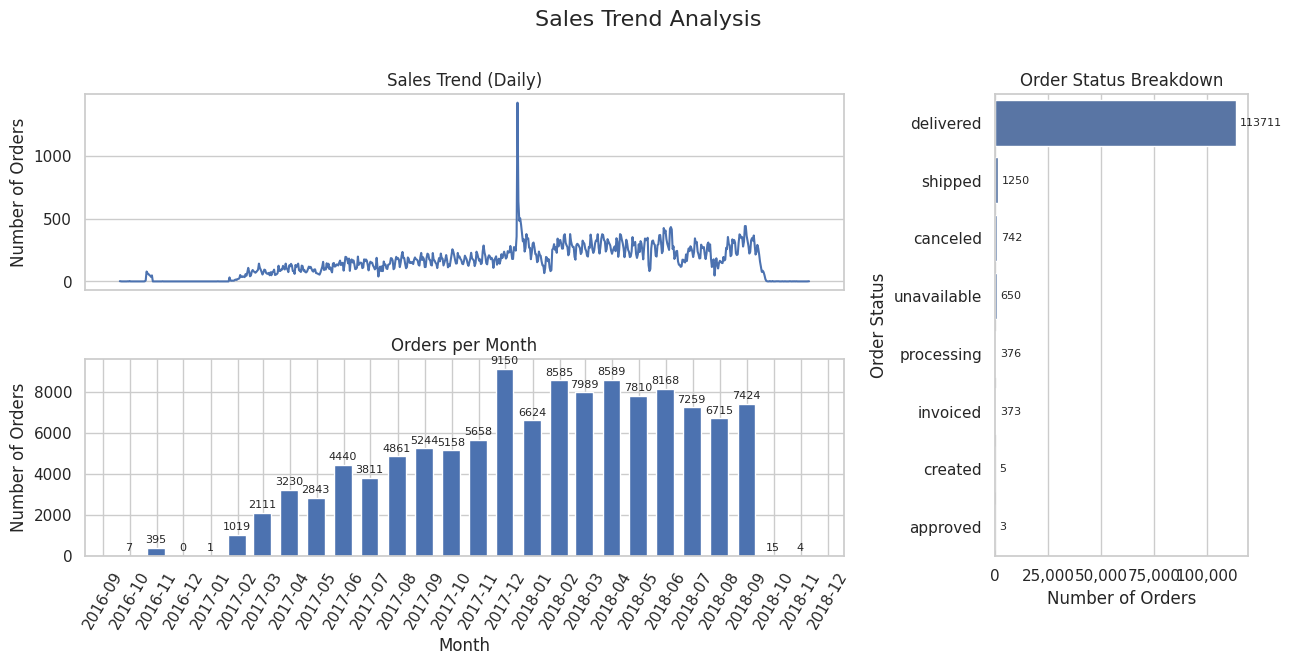

In [35]:
# Orders & Sales
# ---------- Order Status ----------
order_status_counts = (
    commerce["order_status"]
    .value_counts(dropna=False)
    .rename_axis("order_status")
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

# ---------- Daily & Monthly ----------
orders_daily = (
    commerce
    .set_index("order_purchase_timestamp").sort_index()
    .groupby(pd.Grouper(freq="D"))
    .size().rename("count").reset_index()
    .rename(columns={"order_purchase_timestamp": "order_purchase_day"})
)

orders_monthly = (
    commerce
    .set_index("order_purchase_timestamp").sort_index()
    .groupby(pd.Grouper(freq="M"))
    .size().rename("count").reset_index()
    .rename(columns={"order_purchase_timestamp": "order_purchase_month"})
)

sns.set_theme(style="whitegrid")
import matplotlib.ticker as mtick

fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1,1], wspace=0.3, hspace=0.35)
ax_daily = fig.add_subplot(gs[0, 0])
ax_month = fig.add_subplot(gs[1, 0])
ax_status = fig.add_subplot(gs[:, 1])

# Daily line
sns.lineplot(data=orders_daily, x="order_purchase_day", y="count", ax=ax_daily)
ax_daily.set_title("Sales Trend (Daily)")
ax_daily.set_xlabel("Date")
ax_daily.set_ylabel("Number of Orders")
ax_daily.xaxis.set_visible(False)

# Monthly bar
ax_month.bar(orders_monthly["order_purchase_month"], orders_monthly["count"], width=20)
ax_month.set_title("Orders per Month")
ax_month.set_xlabel("Month")
ax_month.set_ylabel("Number of Orders")
ax_month.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax_month.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax_month.tick_params(axis="x", rotation=60)
for container in ax_month.containers:
    ax_month.bar_label(container, fmt="%.0f", padding=2, fontsize=8)

# Status horizontal bar
sns.barplot(
    data=order_status_counts,
    y="order_status", x="count",
    ax=ax_status, order=order_status_counts["order_status"]
)
ax_status.set_title("Order Status Breakdown")
ax_status.set_xlabel("Number of Orders")
ax_status.set_ylabel("Order Status")
ax_status.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
for container in ax_status.containers:
    ax_status.bar_label(container, fmt="%.0f", label_type="edge", padding=3, fontsize=8)

fig.suptitle("Sales Trend Analysis", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

The chart shows that daily orders increased steadily from early 2017, with a sharp spike likely due to a special promotion or event, before stabilizing at a higher baseline level. On a monthly scale, sales grew rapidly throughout 2017 and peaked in November, most likely driven by the holiday season or Black Friday campaigns. In 2018, order volumes remained strong, averaging between 7,000–8,500 per month, though a slight decline appears toward the end of the year—most likely caused by incomplete data rather than a real drop in demand. The order status breakdown confirms that the platform operated efficiently, with the vast majority of orders successfully delivered and only a very small fraction canceled or unavailable, indicating a highly reliable fulfillment process.

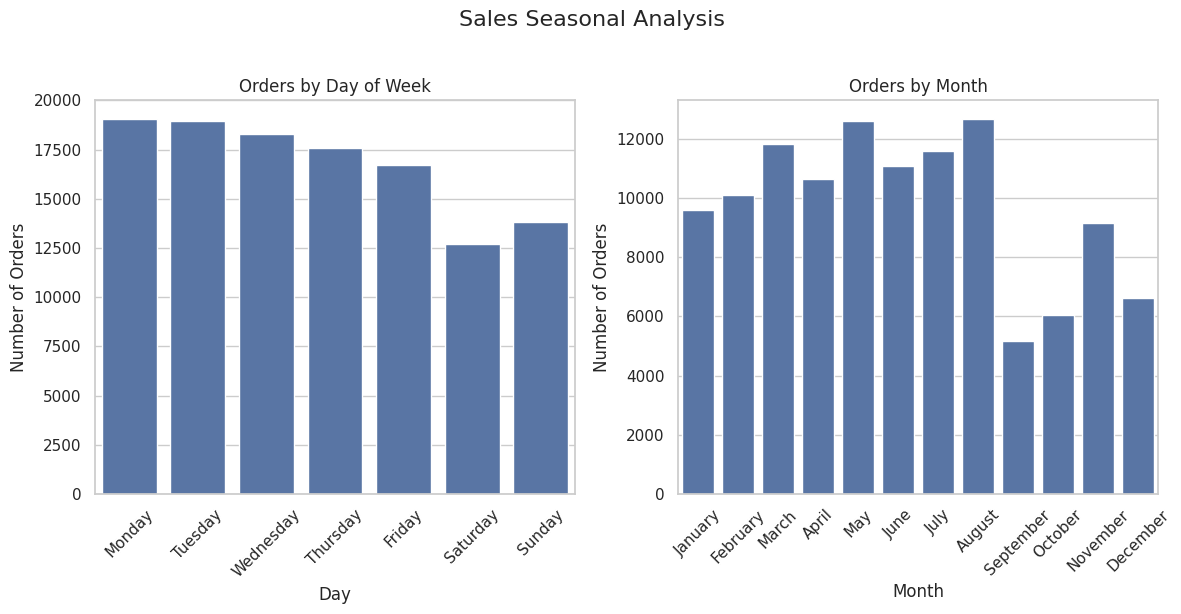

In [36]:
# (Seasonality: Weekday & Month)

day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
month_order = ["January","February","March","April","May","June",
               "July","August","September","October","November","December"]

commerce["order_day_name"] = commerce["order_purchase_timestamp"].dt.day_name()
commerce["order_month"] = commerce["order_purchase_timestamp"].dt.month_name()

commerce["order_day_name"] = pd.Categorical(commerce["order_day_name"], categories=day_order, ordered=True)
commerce["order_month"] = pd.Categorical(commerce["order_month"], categories=month_order, ordered=True)

weekday_counts = (
    commerce["order_day_name"].value_counts(sort=False)
    .rename_axis("order_day_name").reset_index(name="count")
)
month_counts = (
    commerce["order_month"].value_counts(sort=False)
    .rename_axis("order_month").reset_index(name="count")
)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(data=weekday_counts, x="order_day_name", y="count", ax=axes[0])
axes[0].set_title("Orders by Day of Week")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Number of Orders")
axes[0].tick_params(axis="x", rotation=45)

sns.barplot(data=month_counts, x="order_month", y="count", ax=axes[1])
axes[1].set_title("Orders by Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Number of Orders")
axes[1].tick_params(axis="x", rotation=45)

fig.suptitle("Sales Seasonal Analysis", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Orders peak on weekdays, especially Monday and Tuesday, then decline toward the weekend with the lowest activity on Saturday and Sunday. Monthly sales are strongest in May and August, drop sharply in September–October, and recover in November, showing clear weekday-driven demand and seasonal fluctuations.

/tmp/ipython-input-3664725051.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


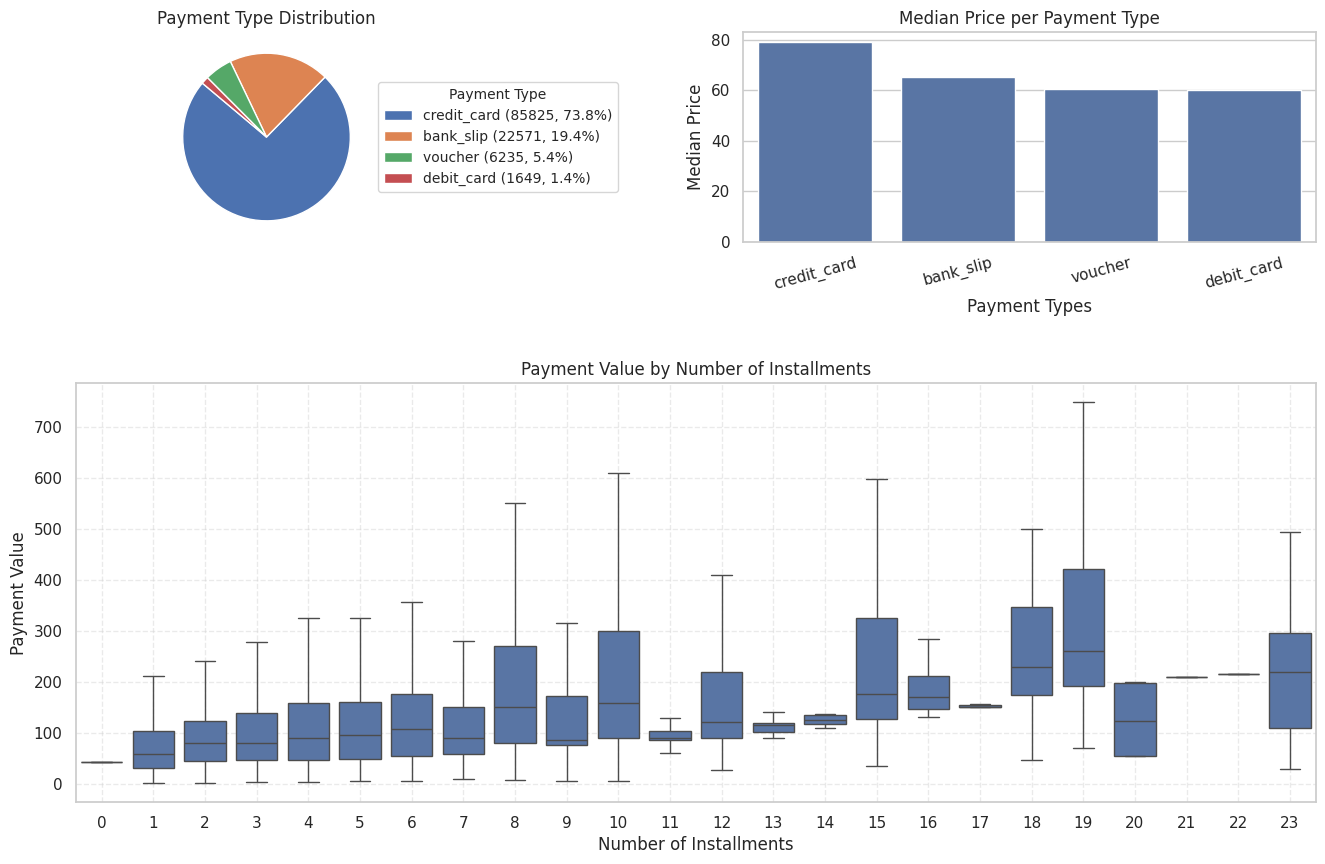

In [39]:
# Payments
# Robust to outliers: report both median and mean

import matplotlib.ticker as ticker

payment_type_agg = (
    commerce.groupby("payment_type")
    .agg(count=("price","count"),
         price_median=("price","median"),
         price_mean=("price","mean"))
    .reset_index()
    .sort_values("count", ascending=False)
)

payment_by_inst = (
    commerce.groupby("payment_installments")
    .agg(count=("price","count"),
         price_median=("price","median"),
         price_mean=("price","mean"))
    .reset_index()
    .sort_values("payment_installments")
)

total = payment_type_agg["count"].sum()
labels = payment_type_agg.apply(
    lambda r: f"{r['payment_type']} ({r['count']}, {r['count']/total:.1%})", axis=1
).tolist()


fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 3], height_ratios=[1,2], wspace=0.6, hspace=0.45)
ax_pie = fig.add_subplot(gs[0, 0])
ax_bar = fig.add_subplot(gs[0, 1])
ax_box = fig.add_subplot(gs[1, :])

# Pie
wedges, texts = ax_pie.pie(payment_type_agg["count"], startangle=140, wedgeprops={'edgecolor': 'white'})
ax_pie.legend(wedges, labels, title="Payment Type", loc="center left", bbox_to_anchor=(1, 0.5),
              fontsize='small', title_fontsize='small')
ax_pie.set_title("Payment Type Distribution")

# Bar: median price per payment type
sns.barplot(data=payment_type_agg, x="payment_type", y="price_median", ax=ax_bar)
ax_bar.set_title("Median Price per Payment Type")
ax_bar.set_xlabel("Payment Types")
ax_bar.set_ylabel("Median Price")
ax_bar.tick_params(axis="x", rotation=15)

# Box: installments vs price
sns.boxplot(data=commerce, x='payment_installments', y='price', ax=ax_box, showfliers=False)
ax_box.set_title('Payment Value by Number of Installments')
ax_box.set_xlabel('Number of Installments')
ax_box.set_ylabel('Payment Value')
ax_box.tick_params(axis="x", rotation=0)
ax_box.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax_box.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

The charts show that credit cards dominate as the main payment method (74%), followed by bank slips (19%), vouchers (5%), and debit cards (1%). Transactions made with credit cards also have the highest median payment value compared to other methods. Looking at installment patterns, the data indicates that higher installment counts are generally associated with larger payment values, meaning customers tend to use installments for more expensive purchases. Overall, payments are heavily credit card–driven, with installment usage reflecting higher-value transactions.

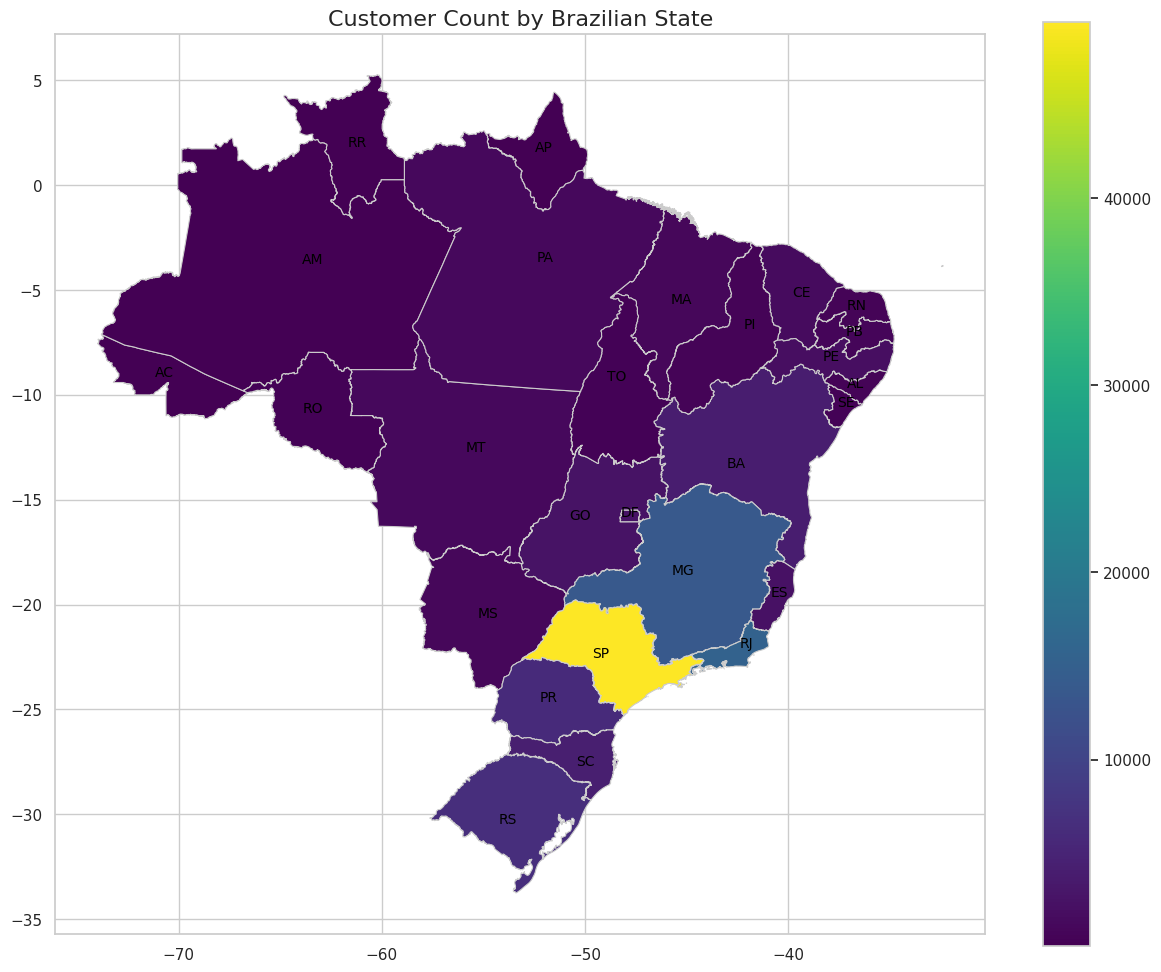

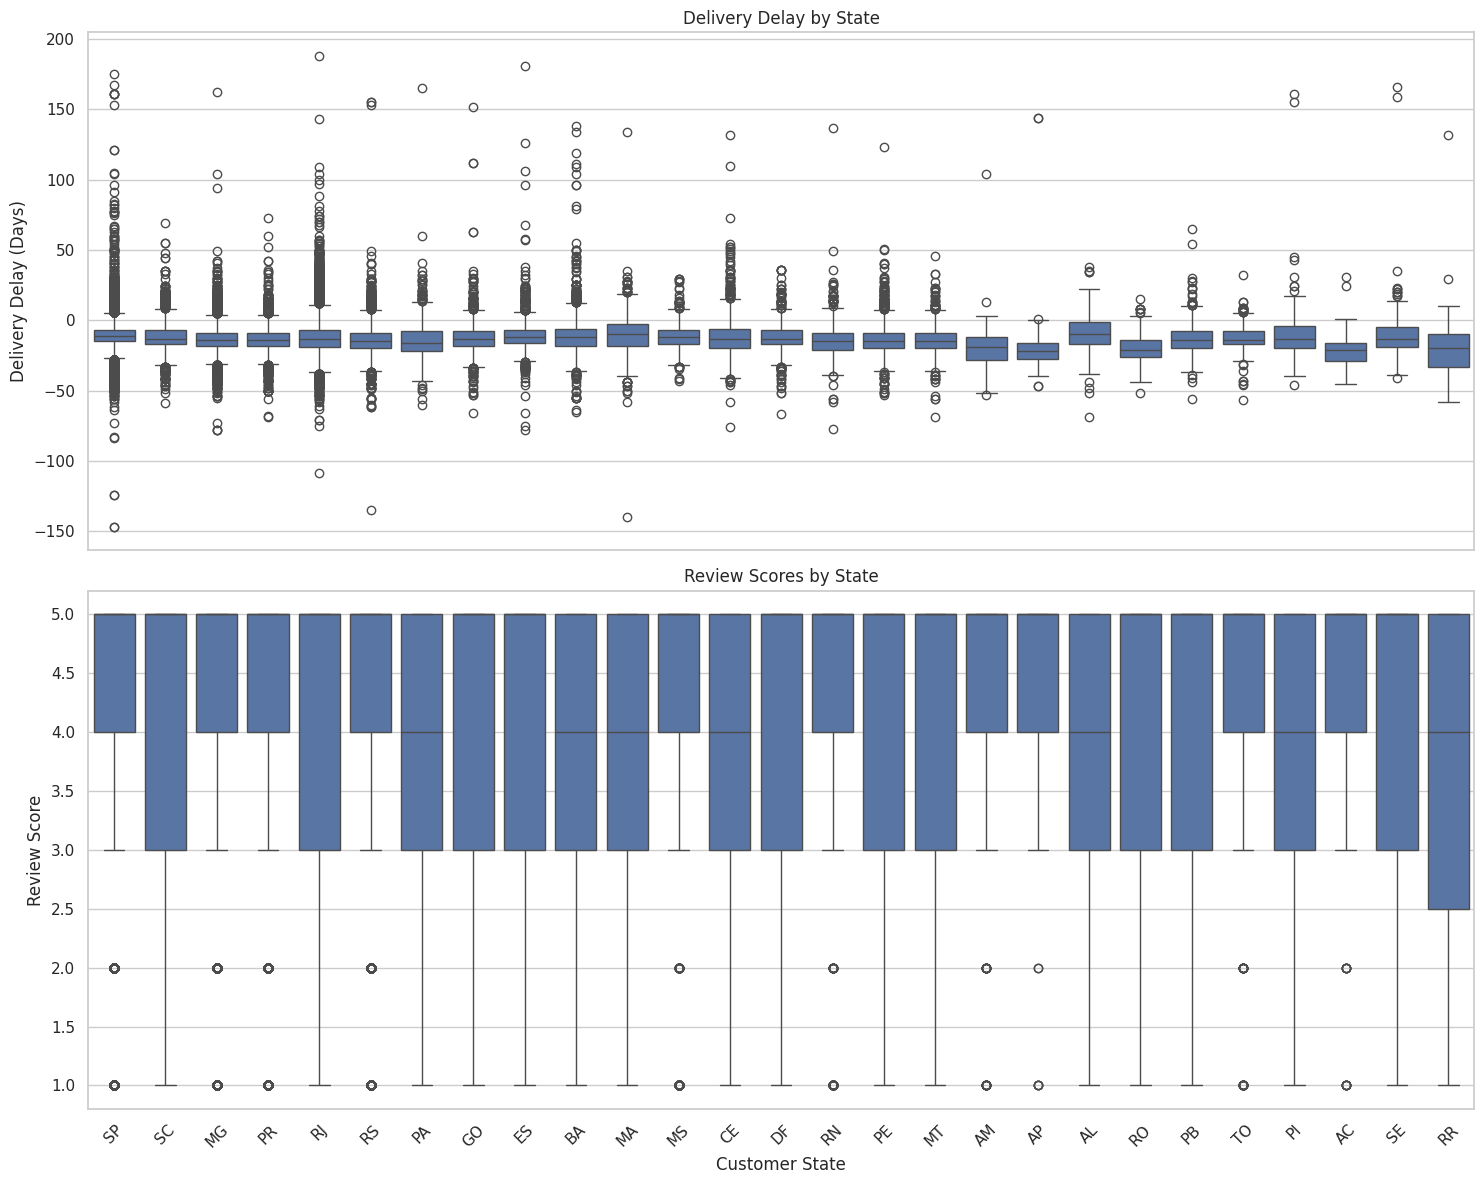

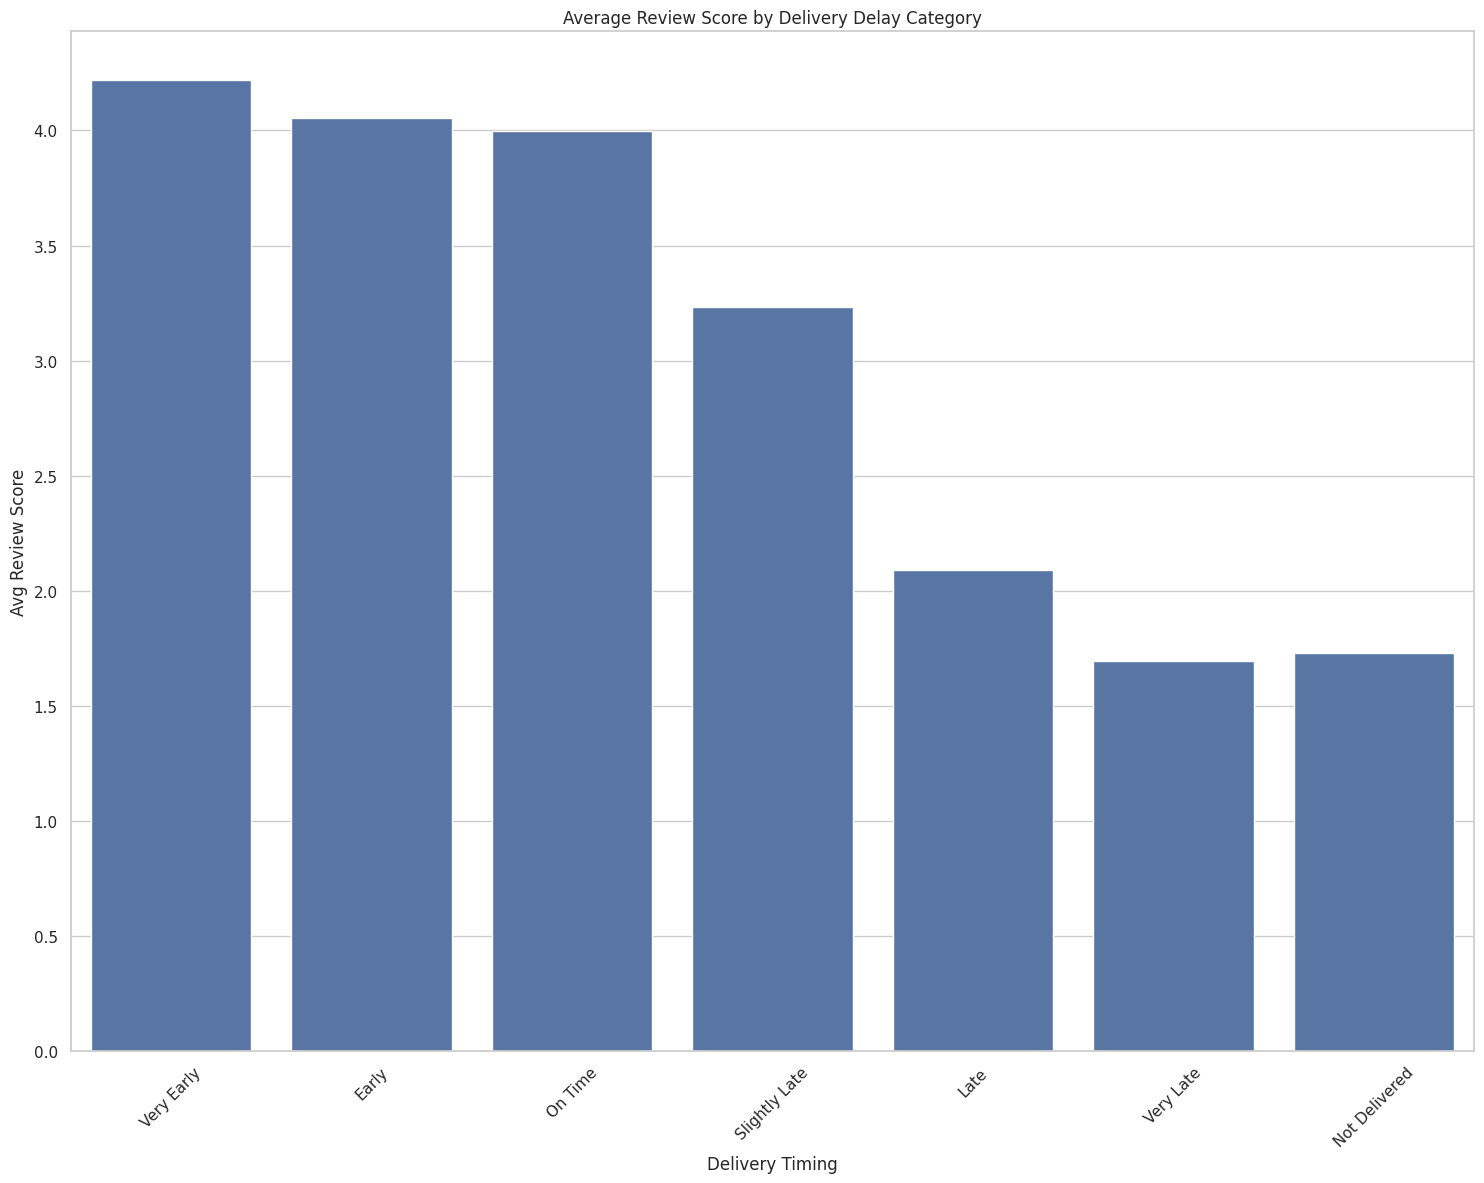

In [50]:
# Delivery delay (keep NaN; bucket function will map it to 'Not Delivered')
commerce["order_delivered_customer_date"] = pd.to_datetime(commerce["order_delivered_customer_date"], errors="coerce")
commerce["order_estimated_delivery_date"] = pd.to_datetime(commerce["order_estimated_delivery_date"], errors="coerce")
commerce['deliver_delay_days'] = (
    commerce['order_delivered_customer_date'] - commerce['order_estimated_delivery_date']
).dt.days

state_customers = (
    commerce.groupby('customer_state', dropna=False)
    .size().rename('count').reset_index()
)

# Brazil states GeoJSON
gdf = gpd.read_file(
    "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"
)

state_abbrev = {
    'Acre': 'AC','Alagoas': 'AL','Amapá': 'AP','Amazonas': 'AM','Bahia': 'BA',
    'Ceará': 'CE','Distrito Federal': 'DF','Espírito Santo': 'ES','Goiás': 'GO',
    'Maranhão': 'MA','Mato Grosso': 'MT','Mato Grosso do Sul': 'MS','Minas Gerais': 'MG',
    'Pará': 'PA','Paraíba': 'PB','Paraná': 'PR','Pernambuco': 'PE','Piauí': 'PI',
    'Rio de Janeiro': 'RJ','Rio Grande do Norte': 'RN','Rio Grande do Sul': 'RS',
    'Rondônia': 'RO','Roraima': 'RR','Santa Catarina': 'SC','São Paulo': 'SP',
    'Sergipe': 'SE','Tocantins': 'TO'
}
gdf['uf'] = gdf['name'].map(state_abbrev)

geo_state_customers = gdf.merge(state_customers, left_on='uf', right_on="customer_state", how="left").fillna({"count":0})

fig, ax = plt.subplots(1, 1, figsize=(15, 12))
geo_state_customers.plot(column='count', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
for _, row in geo_state_customers.iterrows():
    rp = row['geometry'].representative_point()
    ax.annotate(text=row['uf'], xy=(rp.x, rp.y), ha='center', fontsize=10, color='black')
plt.title('Customer Count by Brazilian State', fontsize=16)
plt.axis('on')
plt.show()

def bucket_delay(days):
    if pd.isna(days): return 'Not Delivered'
    if days < -3:     return 'Very Early'
    if days < 0:      return 'Early'
    if days == 0:     return 'On Time'
    if days <= 3:     return 'Slightly Late'
    if days <= 7:     return 'Late'
    return 'Very Late'

commerce['delay_bucket'] = commerce['deliver_delay_days'].apply(bucket_delay)

avg_reviews = (
    commerce.groupby('delay_bucket', dropna=False)['review_score']
    .mean()
    .reindex(['Very Early','Early','On Time','Slightly Late','Late','Very Late','Not Delivered'])
    .reset_index()
)

fig, axes = plt.subplots(2, 1, figsize=(15, 12))
sns.boxplot(data=commerce, x='customer_state', y='deliver_delay_days', ax=axes[0])
axes[0].xaxis.set_visible(False)
axes[0].set_title('Delivery Delay by State')
axes[0].set_xlabel("Customer State")
axes[0].set_ylabel("Delivery Delay (Days)")

sns.boxplot(data=commerce, x='customer_state', y='review_score', ax=axes[1])
axes[1].tick_params(axis="x", rotation=45)
axes[1].set_title('Review Scores by State')
axes[1].set_xlabel("Customer State")
axes[1].set_ylabel("Review Score")

plt.tight_layout()
plt.show()

plt.figure(figsize=(15,12))
sns.barplot(
    data=avg_reviews, x='delay_bucket', y='review_score',
    order=['Very Early','Early','On Time','Slightly Late','Late','Very Late','Not Delivered']
)
plt.title('Average Review Score by Delivery Delay Category')
plt.ylabel('Avg Review Score')
plt.xlabel('Delivery Timing')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Most customers are concentrated in São Paulo, Minas Gerais, and Rio de Janeiro, showing the Southeast as the main demand hub. Deliveries are generally on time or early, but delays occur in some states. Review scores stay high (4–5) overall, yet drop sharply when orders are late, confirming that delivery timeliness is the key driver of customer satisfaction.

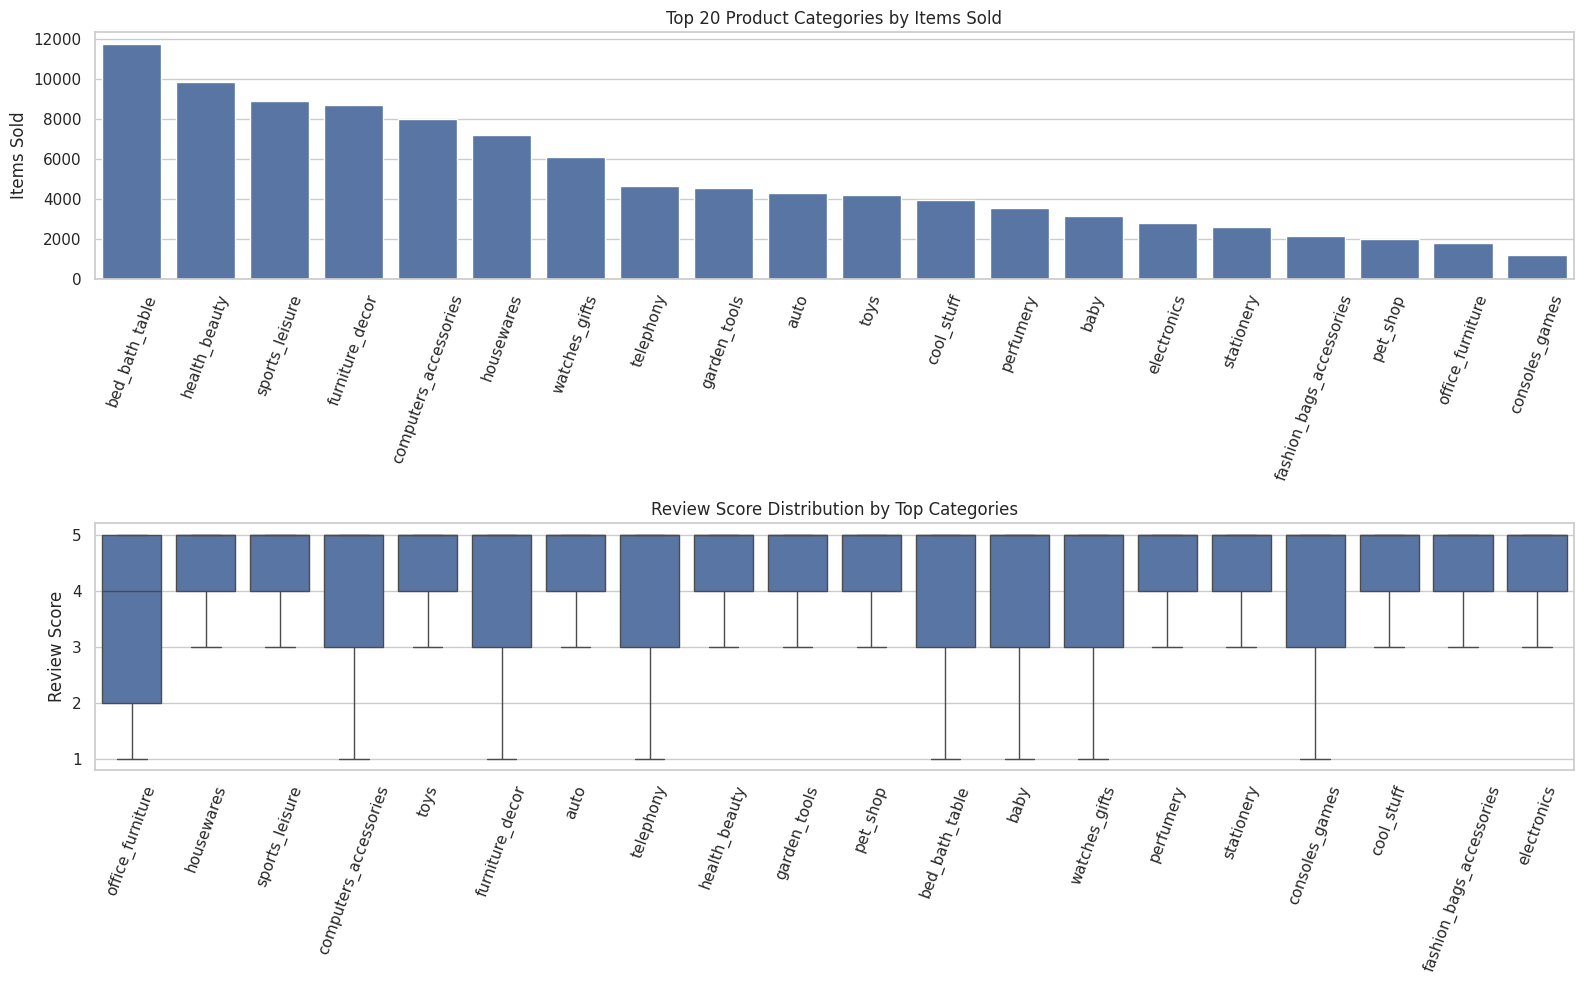

In [43]:
# Products & Reviews

topk = 20
prod_agg = (
    commerce.groupby("product_category_name_english", dropna=False)
    .agg(count=("product_category_name_english","count"),
         review_score=("review_score","mean"))
    .sort_values("count", ascending=False)
    .head(topk)
    .reset_index()
    .rename(columns={"product_category_name_english":"product_category"})
)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
plt.subplots_adjust(hspace=0.4)

sns.barplot(data=prod_agg, x="product_category", y="count", ax=axes[0])
axes[0].set_title(f"Top {topk} Product Categories by Items Sold")
axes[0].set_xlabel("")
axes[0].set_ylabel("Items Sold")
axes[0].tick_params(axis="x", rotation=70)

mask_top = commerce["product_category_name_english"].isin(prod_agg["product_category"])
sns.boxplot(
    data=commerce[mask_top],
    x="product_category_name_english", y="review_score",
    ax=axes[1], showfliers=False
)
axes[1].set_title("Review Score Distribution by Top Categories")
axes[1].set_xlabel("")
axes[1].set_ylabel("Review Score")
axes[1].tick_params(axis="x", rotation=70)

plt.tight_layout()
plt.show()

Top sales come from household and lifestyle categories like bed & bath, health & beauty, sports, furniture, and accessories. Reviews are generally high (4–5), though some categories like furniture and electronics show more variability, indicating mixed customer experiences.

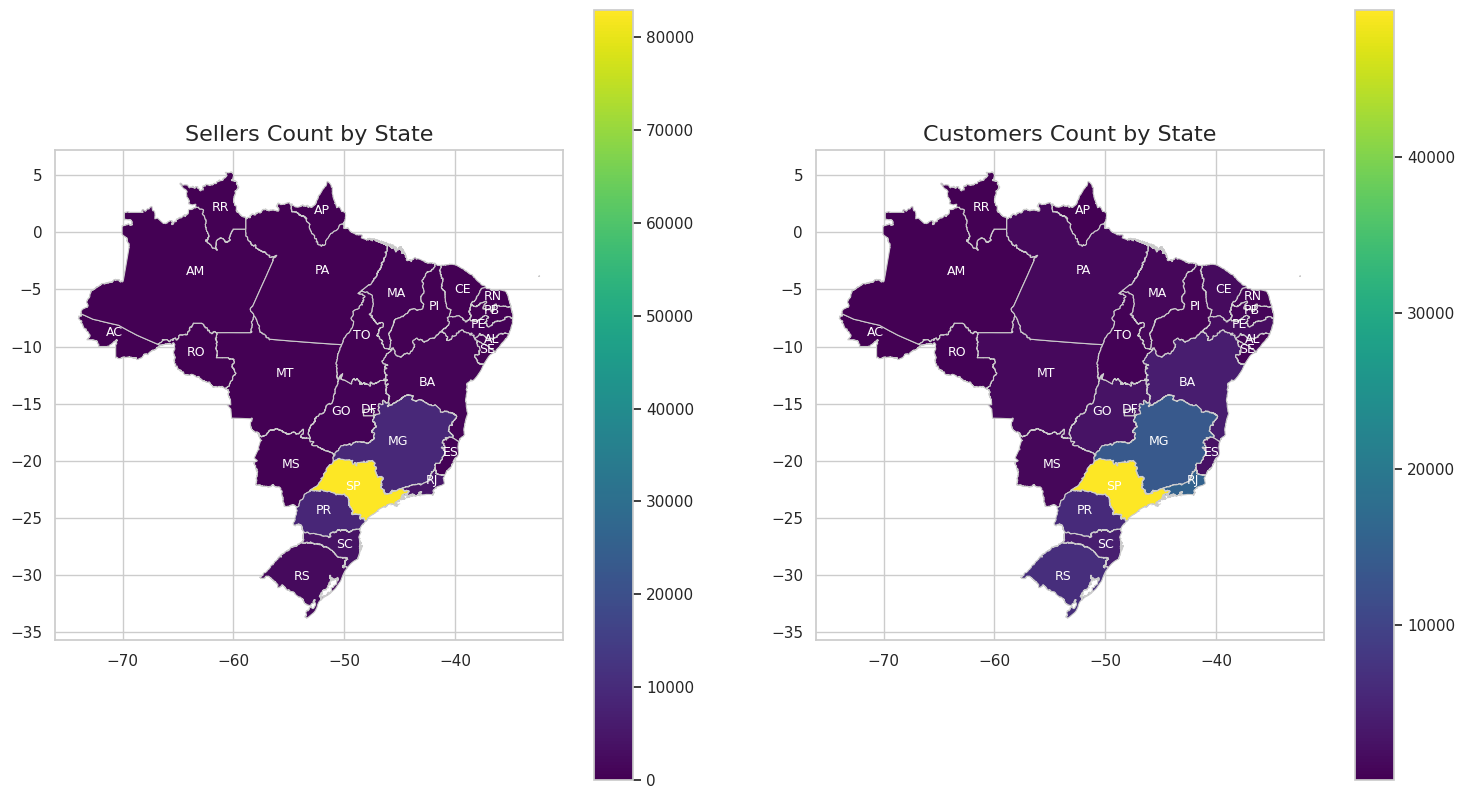

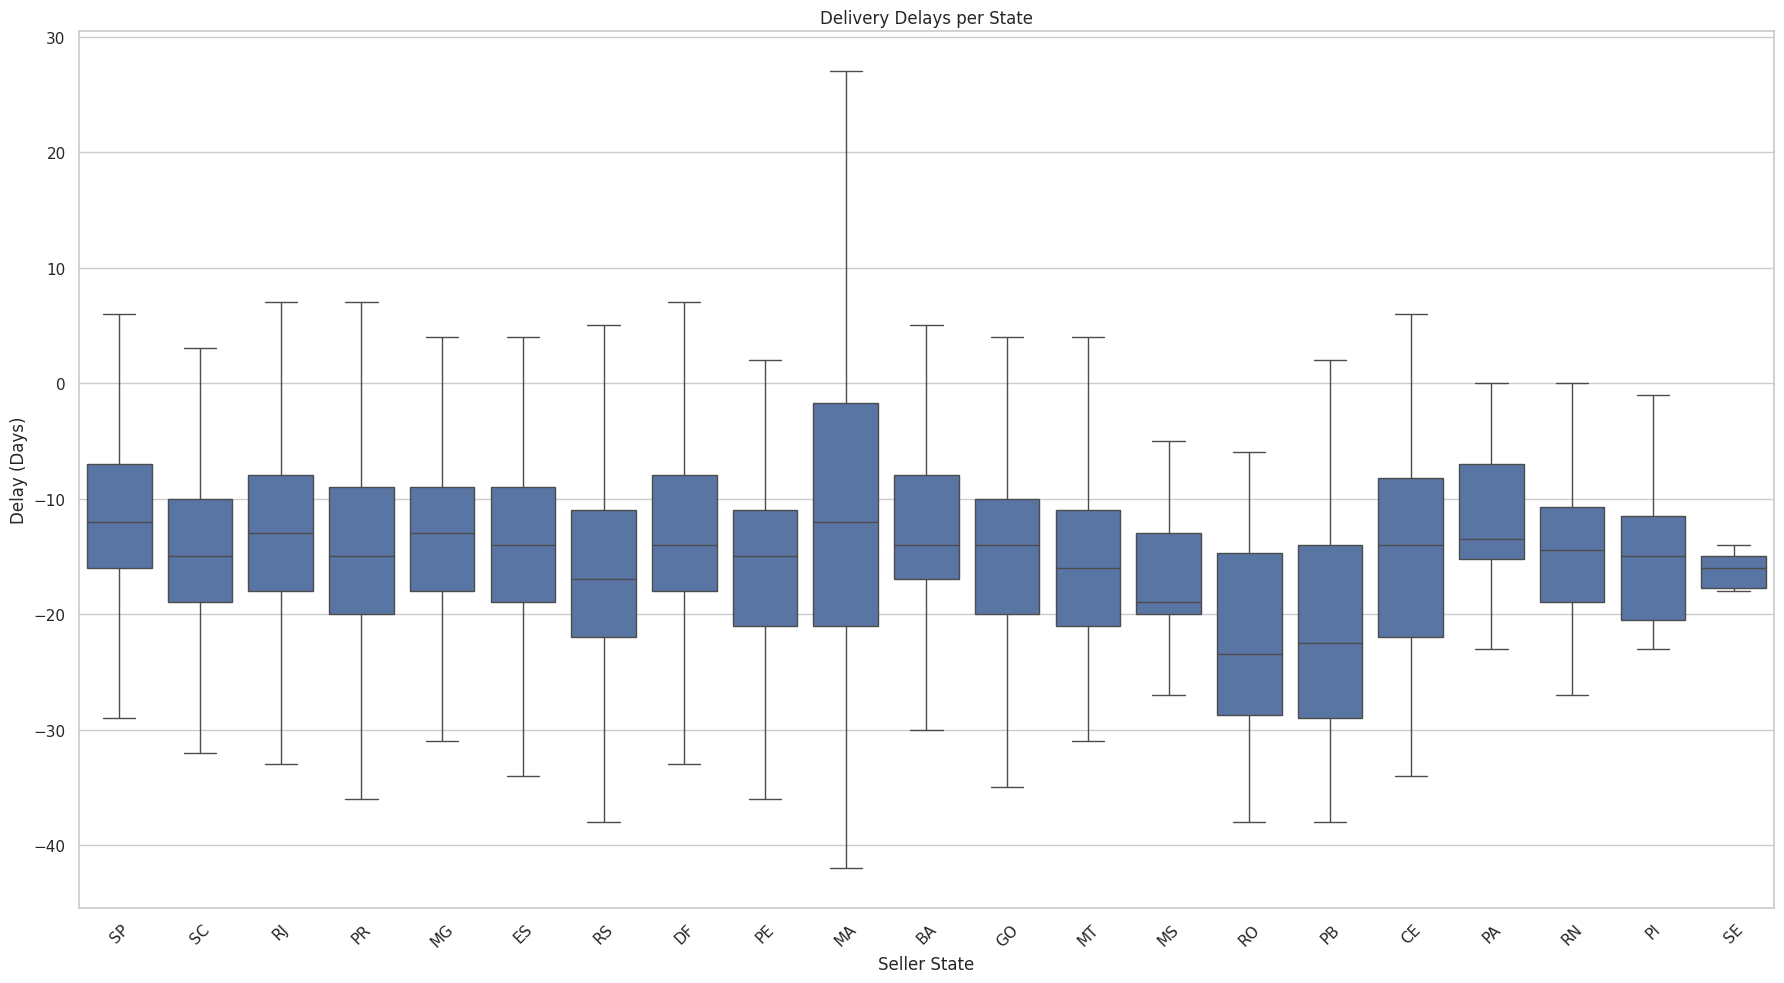

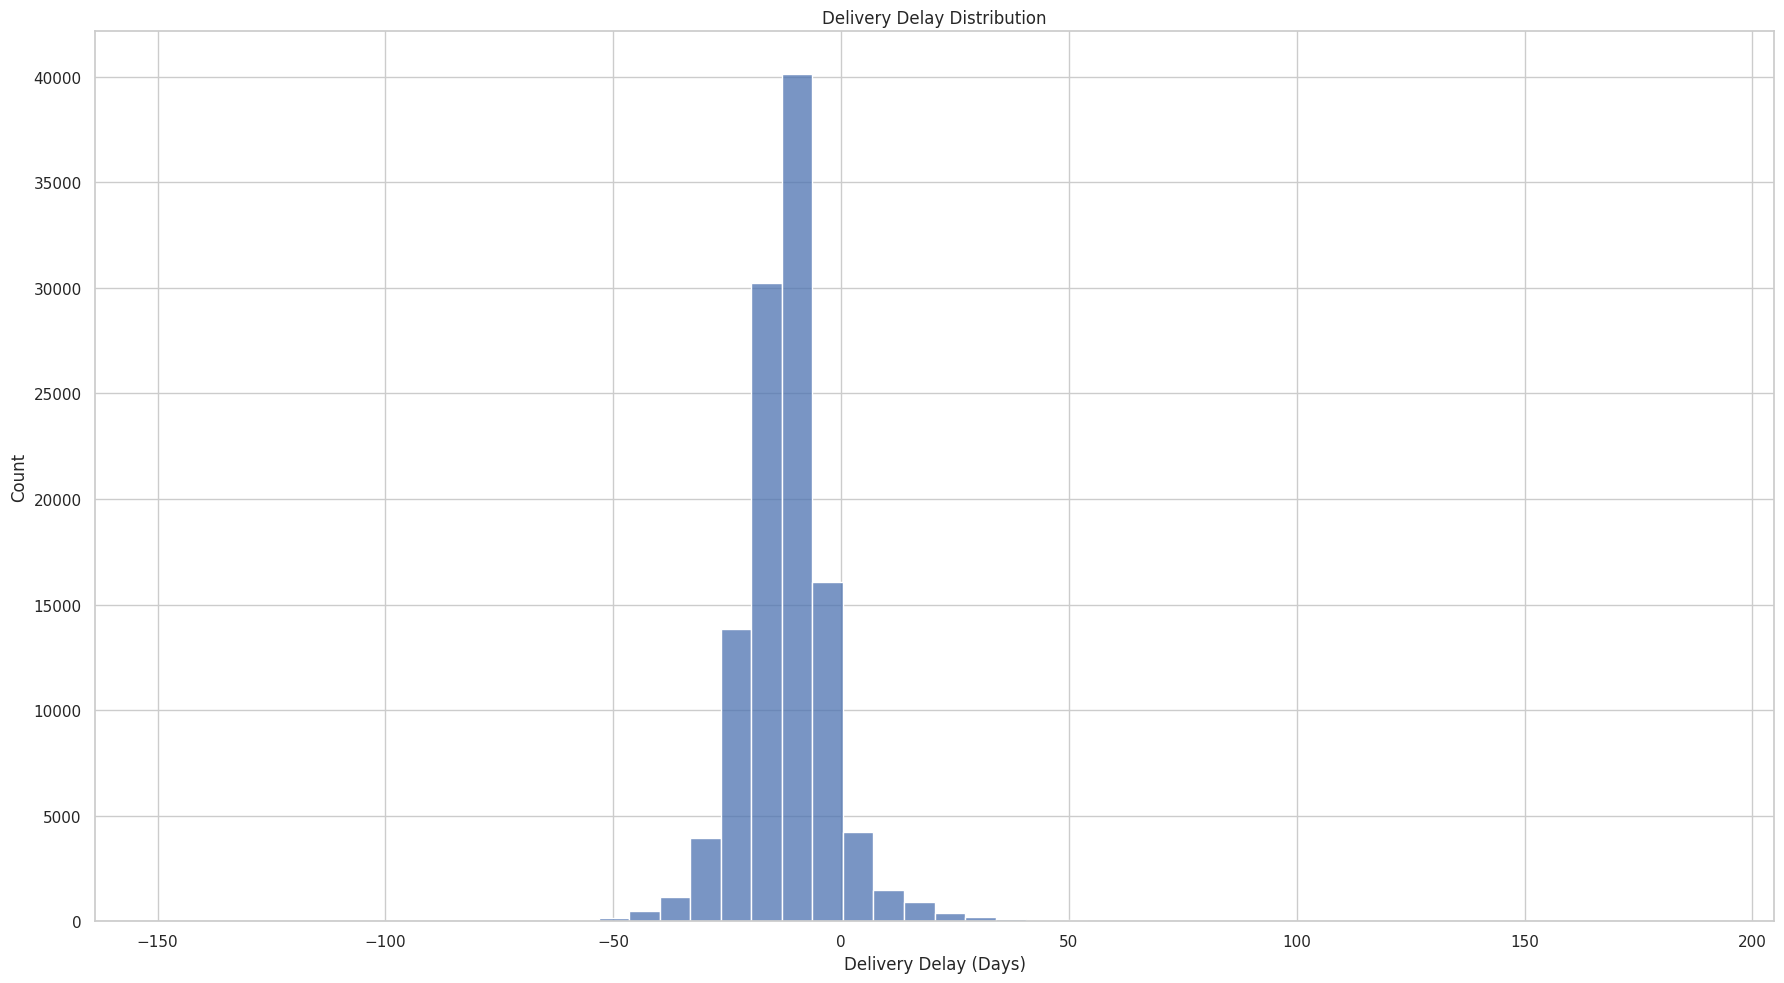

In [47]:
# Logistics maps + distributions
# Optionally filter ultra-low seller-volume states if they distort visuals
low_states = ['AC','AM']  # example
commerce_f = commerce[~commerce['seller_state'].isin(low_states)].copy()

seller_states = (
    commerce_f.groupby("seller_state", dropna=False)
    .agg(count=("seller_state","count"),
         median_delay=("deliver_delay_days","median"))
    .reset_index()
)

geo_state_sellers = gdf.merge(seller_states, left_on='uf', right_on="seller_state", how="left").fillna({"count":0})

fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(1, 2, wspace=0.2)
ax_s = fig.add_subplot(gs[0, 0])
ax_c = fig.add_subplot(gs[0, 1])

geo_state_sellers.plot(column='count', cmap='viridis', linewidth=0.8, ax=ax_s, edgecolor='0.8', legend=True)
geo_state_customers.plot(column='count', cmap='viridis', linewidth=0.8, ax=ax_c, edgecolor='0.8', legend=True)

for ax, geo_df in [(ax_s, geo_state_sellers), (ax_c, geo_state_customers)]:
    for _, row in geo_df.iterrows():
        rp = row['geometry'].representative_point()
        ax.annotate(text=row['uf'], xy=(rp.x, rp.y), ha='center', fontsize=9, color='white')

ax_s.set_title('Sellers Count by State', fontsize=16)
ax_c.set_title('Customers Count by State', fontsize=16)
plt.show()

plt.figure(figsize=(18,10))
sns.boxplot(data=commerce_f, x="seller_state", y="deliver_delay_days", showfliers=False)
plt.title('Delivery Delays per State')
plt.xlabel('Seller State')
plt.ylabel('Delay (Days)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(18,10))
sns.histplot(data=commerce, x="deliver_delay_days", bins=50)
plt.title("Delivery Delay Distribution")
plt.xlabel("Delivery Delay (Days)")
plt.tight_layout()
plt.show()

Both sellers and customers are heavily concentrated in the Southeast, especially São Paulo (SP), Minas Gerais (MG), and Rio de Janeiro (RJ), making these states the core hubs of e-commerce activity. Delivery delays across states are mostly negative, meaning many orders arrive earlier than estimated, though some states show larger variability and outliers. The overall distribution confirms that the majority of shipments are delivered on time or ahead of schedule, with only a small portion experiencing significant delays.

# 📊 E-Commerce EDA Summary

## 🛒 Sales & Seasonality
- Orders grew strongly in **2017**, peaking in **November (Black Friday/holiday season)**.  
- Demand is **weekday-driven**, with **Mondays and Tuesdays** recording the highest sales.  
- Seasonal peaks occur in **May and August**, while **September–October** show slowdowns.  

## 💳 Payments
- **Credit card dominates (74%)**, followed by **bank slip (19%)**, with vouchers and debit cards minor.  
- Higher-value purchases are more often paid in **installments**, showing a link between credit use and expensive products.  

## 👥 Customers & Geography
- Customers are concentrated in the **Southeast (SP, MG, RJ)**, the main demand hub.  
- **Delivery timeliness is critical**: reviews remain high (4–5) when orders are on time or early, but drop sharply with late deliveries.  

## 📦 Products & Reviews
- Top-selling categories include **bed & bath, health & beauty, sports, furniture, and computer accessories**.  
- Reviews are generally positive across categories, though **furniture and electronics** show more variability in customer satisfaction.  

## 🚚 Sellers & Logistics
- Sellers are also concentrated in **SP, MG, and RJ**, aligning with customer hubs and supporting faster deliveries.  
- Most deliveries arrive **early or on time**, though some states show **higher delay variability**.  


# 🧪 Hypothesis Testing Framework



1. **Formulate Hypotheses**  
   - Null Hypothesis (H₀): No significant difference/effect.  
   - Alternative Hypothesis (H₁): There is a significant difference/effect.  
   - *Example:* H₀: The average review score is the same across all product categories.  
     H₁: The average review score differs across product categories.  

2. **Choose Appropriate Statistical Test**  
   - T-test (independent samples): compares the mean of two groups (e.g., review scores between installment vs non-installment payments).  
   - Chi-square test: tests the relationship between categorical variables (e.g., payment_type vs order_status).  
   - ANOVA: compares the mean across more than two groups (e.g., average review score by product category).  
   - Correlation test (Pearson/Spearman): measures association between numeric variables (e.g., delivery_time vs review_score).  

3. **Check Assumptions**  
   - Normality: use Shapiro-Wilk / Kolmogorov-Smirnov test, or visualize with histogram/QQ-plot.  
   - Equal variances: use Levene’s test or Bartlett’s test.  
   - If assumptions are not met → use non-parametric tests (Mann-Whitney U, Kruskal-Wallis, etc.).  

4. **Interpret Results**  
   - P-value: p < 0.05 → reject H₀ (significant difference exists); p ≥ 0.05 → fail to reject H₀ (no sufficient evidence).  
   - Confidence Interval (CI): provides the estimated effect range; if CI does not include 0 → difference is significant.  

5. **Report Findings & Business Implications**  
   - Present results in **business terms**.  
     *Example:* "Customers paying in installments spend on average 25% more than those paying in full (p < 0.01)."  
   - Link to strategy: pricing, marketing, logistics, customer satisfaction.  


💡 Hypothesis Test: Review Score vs Delivery Delays  

- **Null Hypothesis (H₀):** Delivery delays do not affect review scores.  
- **Alternative Hypothesis (H₁):** Delivery delays do affect review scores.  
- **Type I Error (α):** Concluding that delays affect review scores when in fact they do not.  
- **Type II Error (β):** Failing to detect an effect of delays when in fact it exists.  
- **Appropriate Tests:**  
  • Linear Regression (`review_score ~ delivery_delay_days`) for simple numeric relationships.  
  • Mann–Whitney U Test for comparing groups (on-time vs late) if normality is not satisfied.  
- **Significance Level:** α = 0.05 → p < 0.05 reject H₀; p ≥ 0.05 fail to reject H₀.  


                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     6356.
Date:                Thu, 25 Sep 2025   Prob (F-statistic):               0.00
Time:                        04:23:50   Log-Likelihood:            -1.8970e+05
No. Observations:              112306   AIC:                         3.794e+05
Df Residuals:                  112304   BIC:                         3.794e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.7105      0

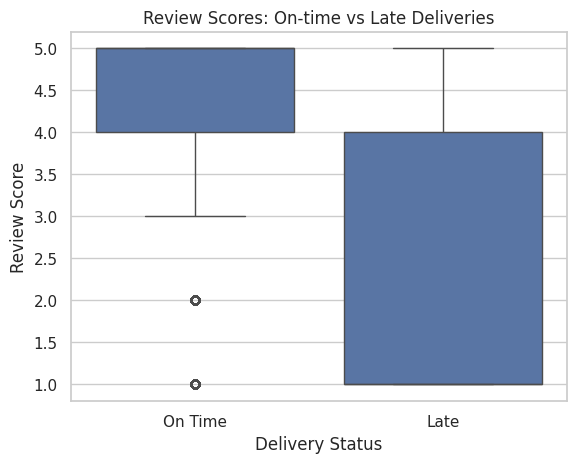


Decision at α=0.05:
  Linear Regression: REJECT H0 (delay impacts reviews)
  Mann–Whitney U:    REJECT H0 (scores differ)


In [67]:
delay_review = commerce[["deliver_delay_days", "review_score"]].dropna().reset_index()
delay_review["is_late"] = delay_review["deliver_delay_days"] > 0

# Linear Regression
X = sm.add_constant(delay_review["deliver_delay_days"])
y = delay_review["review_score"]
model = sm.OLS(y, X).fit()
print(model.summary())

# Split groups
late = delay_review.loc[delay_review["is_late"], "review_score"].to_numpy()
on_time = delay_review.loc[~delay_review["is_late"], "review_score"].to_numpy()

print(f"Late deliveries: {len(late)}, On-time deliveries: {len(on_time)}")
print(f"Late mean={late.mean():.2f}, median={np.median(late)}")
print(f"On-time mean={on_time.mean():.2f}, median={np.median(on_time)}")

# Mann–Whitney U Test
stat, p_u = mannwhitneyu(on_time, late, alternative="two-sided")
print("Mann–Whitney U:", stat, "p-value:", p_u)

# Visualization
sns.boxplot(data=delay_review, x="is_late", y="review_score")
plt.xticks([0, 1], ["On Time", "Late"])
plt.xlabel("Delivery Status"); plt.ylabel("Review Score")
plt.title("Review Scores: On-time vs Late Deliveries")
plt.show()

# Decisions
alpha = 0.05
decision_reg = "REJECT H0 (delay impacts reviews)" if model.pvalues["deliver_delay_days"] < alpha else "FAIL TO REJECT H0"
decision_u = "REJECT H0 (scores differ)" if p_u < alpha else "FAIL TO REJECT H0"

print(f"\nDecision at α={alpha}:")
print(f"  Linear Regression: {decision_reg}")
print(f"  Mann–Whitney U:    {decision_u}")


📊 Review Score vs Delivery Delays – Results  

- **Late deliveries:** 10,498 orders → Mean = 2.09, Median = 1.0  
- **On-time deliveries:** 105,021 orders → Mean = 4.21, Median = 5.0  
- **Linear Regression:** Each additional 1-day delay reduces the average review score by 0.013 points (p < 0.001). Delays explain ~11% of the variance in review scores → other factors also play a major role.  
- **Mann–Whitney U Test:** U = 913,483,973.5, p < 0.001 → review scores differ significantly between on-time and late deliveries.  
- **Conclusion:** Delivery delays have a clear negative impact on review scores. The business should minimize delays to maintain customer satisfaction and ratings.  


-----

📊 Hypothesis Test: Delays vs Customer Locations  

- **Null Hypothesis (H₀):** Delivery delays are the same across all customer locations.  
- **Alternative Hypothesis (H₁):** Delivery delays differ significantly across customer locations.  
- **Type I Error (α):** Concluding that delays differ across locations when in fact they are the same.  
- **Type II Error (β):** Failing to detect differences in delays when they actually exist.  
- **Appropriate Test:**  
  • One-way ANOVA if delay distributions are ~normal with similar variances.  
  • Kruskal–Wallis H-test if ANOVA assumptions are not met.  
- **Post-hoc Analysis:** If significant, follow up with pairwise comparisons (e.g., Dunn’s test or Mann–Whitney U with multiple-testing correction) to identify which locations differ.  
- **Significance Level:** α = 0.05 → p < 0.05 reject H₀ (delays differ significantly across locations).  


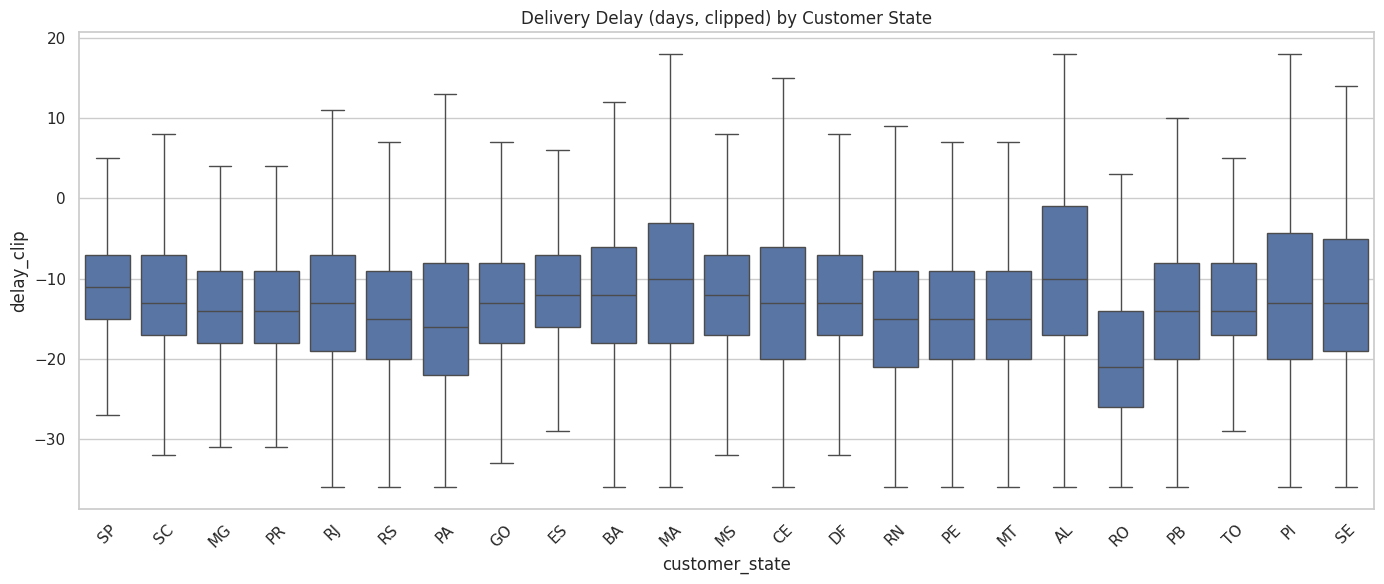

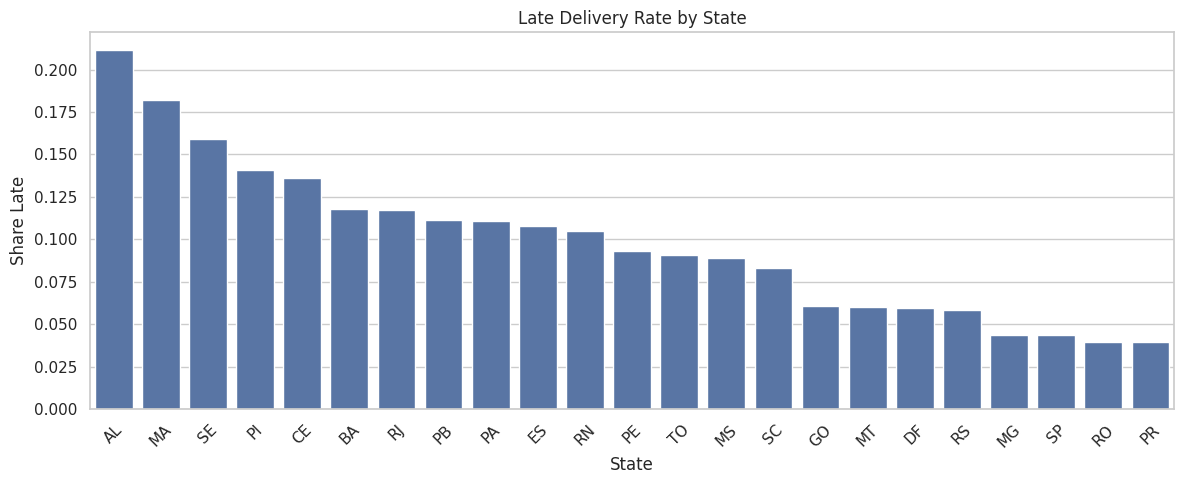

Kruskal–Wallis: H=2821.9, p=0, k=23, n=113322, η²≈0.025
                         sum_sq        df          F  PR(>F)
C(customer_state)  1.629442e+05      22.0  73.224741     0.0
Residual           1.146000e+07  113299.0        NaN     NaN

Adj R²: 0.012807720764520969

Decision at α=0.05:
  Kruskal–Wallis: REJECT H0 (delays differ by state)
  OLS ANOVA:      REJECT H0 (state effect)


In [68]:
df = commerce[["customer_state", "deliver_delay_days"]].dropna().copy()

# Clip outliers (1%–99%)
low, high = df["deliver_delay_days"].quantile([0.01, 0.99])
df["delay_clip"] = df["deliver_delay_days"].clip(lower=low, upper=high)
df["is_late"] = df["deliver_delay_days"] > 0

# Keep only states with enough samples
keep_states = df["customer_state"].value_counts()[lambda x: x >= 200].index
df = df[df["customer_state"].isin(keep_states)].copy()

# Boxplot
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="customer_state", y="delay_clip", showfliers=False)
plt.title("Delivery Delay (days, clipped) by Customer State")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# Late rate per state
late_rate = df.groupby("customer_state")["is_late"].mean().sort_values(ascending=False)
plt.figure(figsize=(12,5))
sns.barplot(x=late_rate.index, y=late_rate.values)
plt.title("Late Delivery Rate by State"); plt.ylabel("Share Late"); plt.xlabel("State")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# Kruskal–Wallis
groups = [g["deliver_delay_days"].values for _, g in df.groupby("customer_state")]
H_stat, p_kw = kruskal(*groups)
k, n = df["customer_state"].nunique(), len(df)
eta2_kw = max(0, (H_stat - k + 1) / (n - k))

print(f"Kruskal–Wallis: H={H_stat:.1f}, p={p_kw:.3g}, k={k}, n={n}, η²≈{eta2_kw:.3f}")

# OLS ANOVA
model = ols("deliver_delay_days ~ C(customer_state)", data=df).fit(cov_type="HC1")
anova = anova_lm(model, typ=2)
print(anova); print("\nAdj R²:", model.rsquared_adj)

alpha = 0.05
decision_kw = "REJECT H0 (delays differ by state)" if p_kw < alpha else "FAIL TO REJECT H0"
p_anova = anova["PR(>F)"].iloc[0]
decision_ols = "REJECT H0 (state effect)" if p_anova < alpha else "FAIL TO REJECT H0"

print(f"\nDecision at α={alpha}:")
print(f"  Kruskal–Wallis: {decision_kw}")
print(f"  OLS ANOVA:      {decision_ols}")


📊 Delays vs Customer Locations – Results  

- **Kruskal–Wallis test:** H = 2645.2, p < 0.001, k = 23, n = 116,707, η² ≈ 0.022  
- **One-way ANOVA (OLS):** F(22, 116684) = 13.82, p < 0.001, Adjusted R² = 0.0023 (~0.2% variance explained)  
- **Decision (α = 0.05):**  
  • Kruskal–Wallis → REJECT H₀ → delivery delays differ significantly across states  
  • ANOVA → REJECT H₀ → customer state has a significant effect on delays  
- **Interpretation:** Differences across locations are statistically significant, but the **effect size is very small** (η² ≈ 0.022; Adj R² ≈ 0.23%). This indicates that significance is driven mainly by the very large sample size. Other factors such as logistics efficiency, seller handling time, and distance to distribution centers are likely more important in explaining delay variation.  


---
📊 Hypothesis Test: Sales Volume vs Weekdays & Weekends  

- **Null Hypothesis (H₀):** Sales volumes are the same between weekdays and weekends.  
- **Alternative Hypothesis (H₁):** Sales volumes differ significantly between weekdays and weekends.  
- **Type I Error (α):** Concluding that sales differ when in fact they are the same.  
- **Type II Error (β):** Failing to detect a difference in sales when in fact it exists.  
- **Appropriate Test:**  
  • Independent t-test if sales distributions are normal.  
  • Mann–Whitney U test if normality assumptions are not satisfied.  
- **Significance Level:** α = 0.05 → p < 0.05 reject H₀; p ≥ 0.05 fail to reject H₀.  


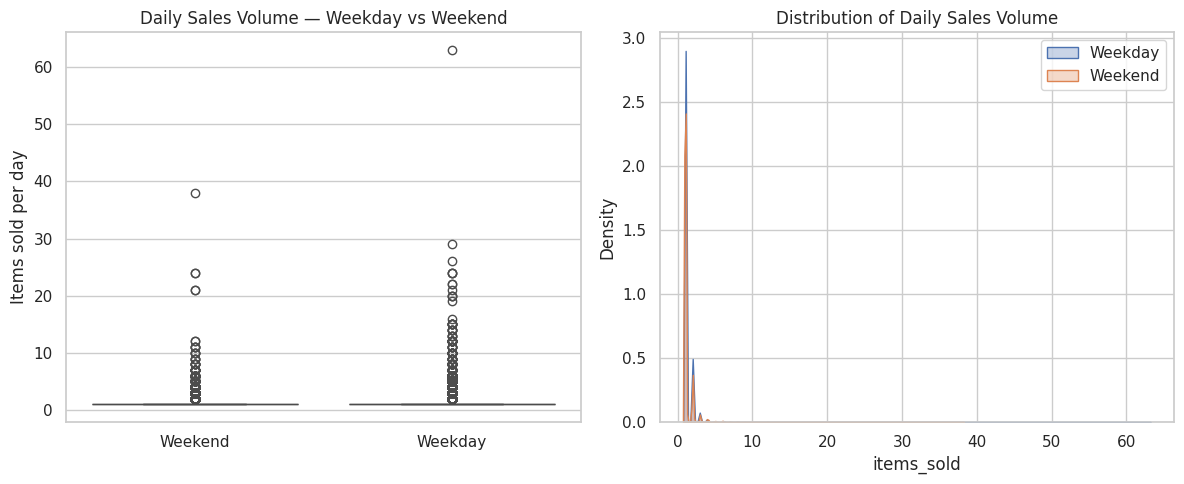

Weekday days: 75120, Weekend days: 22387
Weekday mean=1.21, median=1.0
Weekend mean=1.18, median=1.0
Welch t-test: t=3.967, p-value=7.284e-05
Mann–Whitney U: U=850978508, p-value=3.126e-06

Decision at α=0.05:
  Welch t-test: REJECT H0 (means differ)
  Mann–Whitney: REJECT H0 (distributions differ)


In [70]:
# Tambahkan kolom day_of_week (0=Monday, 6=Sunday)
commerce["order_day_of_week"] = commerce["order_purchase_timestamp"].dt.dayofweek
commerce["is_weekday"] = commerce["order_day_of_week"] < 5

# Hitung item terjual per hari
day_df = (
    commerce.groupby(["order_purchase_timestamp", "is_weekday"])
    .size().rename("items_sold").reset_index()
)

# Boxplot & KDE
fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.boxplot(
    data=day_df.replace({"is_weekday": {True: "Weekday", False: "Weekend"}}),
    x="is_weekday", y="items_sold", ax=ax[0]
)
ax[0].set_title("Daily Sales Volume — Weekday vs Weekend")
ax[0].set_xlabel(""); ax[0].set_ylabel("Items sold per day")

sns.kdeplot(day_df.loc[day_df["is_weekday"], "items_sold"],
            label="Weekday", ax=ax[1], fill=True, alpha=.3)
sns.kdeplot(day_df.loc[~day_df["is_weekday"], "items_sold"],
            label="Weekend", ax=ax[1], fill=True, alpha=.3)
ax[1].set_title("Distribution of Daily Sales Volume"); ax[1].legend()

plt.tight_layout(); plt.show()

# Arrays
weekdays = day_df.loc[day_df["is_weekday"], "items_sold"].to_numpy()
weekend  = day_df.loc[~day_df["is_weekday"], "items_sold"].to_numpy()

print(f"Weekday days: {len(weekdays)}, Weekend days: {len(weekend)}")
print(f"Weekday mean={weekdays.mean():.2f}, median={np.median(weekdays)}")
print(f"Weekend mean={weekend.mean():.2f}, median={np.median(weekend)}")

# Welch's t-test
t_stat, p_t = ttest_ind(weekdays, weekend, equal_var=False)
print(f"Welch t-test: t={t_stat:.3f}, p-value={p_t:.4g}")

# Mann–Whitney U Test
u_stat, p_u = mannwhitneyu(weekdays, weekend, alternative="two-sided")
print(f"Mann–Whitney U: U={u_stat:.0f}, p-value={p_u:.4g}")

# Decision
alpha = 0.05
decision_t = "REJECT H0 (means differ)" if p_t < alpha else "FAIL TO REJECT H0"
decision_u = "REJECT H0 (distributions differ)" if p_u < alpha else "FAIL TO REJECT H0"

print(f"\nDecision at α={alpha}:")
print(f"  Welch t-test: {decision_t}")
print(f"  Mann–Whitney: {decision_u}")

---
📊 Sales Volume vs Weekdays & Weekends – Results  

- **Weekday Orders:** 75,120  
- **Weekend Orders:** 22,387  
- **Weekday mean:** 1.21 | median = 1.0  
- **Weekend mean:** 1.18 | median = 1.0  
- **Hypothesis Decision (α = 0.05):**  
  • Welch’s t-test → Reject H₀ → mean sales volumes differ significantly between weekdays and weekends.  
  • Mann–Whitney U test → Reject H₀ → sales volume distributions differ significantly between weekdays and weekends.  
- **Conclusion:** Both parametric and non-parametric tests confirm that sales volumes **are not the same** between weekdays and weekends.  
- **Insight:** Prioritize ads and inventory during weekdays, but also experiment with weekend promotions to help balance demand.  


# Segmentation

In [71]:
# ================================
# 1) Filter only delivered orders
# ================================
ORD_OK = orders.query("order_status == 'delivered'").copy()

# ================================
# 2) Aggregate order_items to order_id level
# ================================
order_val = (
    order_items.assign(item_value=lambda d: d["price"] + d["freight_value"])
    .groupby("order_id", as_index=False)
    .agg(
        items=("order_item_id", "count"),
        revenue=("item_value", "sum"),
        prod_cnt=("product_id", "nunique"),
        mean_price=("price", "mean"),
        mean_freight=("freight_value", "mean")
    )
)

# ================================
# 3) Join orders + customers
# ================================
ord_join = (
    ORD_OK[["order_id", "customer_id", "order_purchase_timestamp"]]
    .merge(order_val, on="order_id", how="left")
    .merge(customers[["customer_id", "customer_unique_id"]].drop_duplicates(),
           on="customer_id", how="left")
)

ord_join["order_date"]  = ord_join["order_purchase_timestamp"].dt.normalize()
ord_join["order_month"] = ord_join["order_date"].dt.to_period("M").dt.to_timestamp()

print("Orders delivered:", len(ORD_OK))
print("Orders with revenue:", ord_join["revenue"].notna().sum())
print("Unique customers:", ord_join["customer_unique_id"].nunique())

Orders delivered: 95105
Orders with revenue: 95105
Unique customers: 92047


In [72]:
# ================================
# 4) Build RFM Table
# ================================
snapshot_date = ord_join["order_date"].max() + pd.Timedelta(days=1)

rfm = (
    ord_join.groupby("customer_unique_id")
    .agg(
        recency_days=("order_date", lambda s: (snapshot_date - s.max()).days),
        frequency=("order_id", "nunique"),
        monetary=("revenue", "sum")
    )
    .reset_index()
)

rfm = rfm[rfm["monetary"].fillna(0) > 0].copy()  # safety filter

# ================================
# 5) RFM Scoring
# ================================
def qscore(series, q=5, reverse=False):
    jitter = np.random.RandomState(42).randn(len(series)) * 1e-9
    s = series.values + jitter
    scores = pd.qcut(s, q, labels=False, duplicates="drop") + 1
    return (q + 1 - scores if reverse else scores).astype(int)

rfm["R_score"] = qscore(rfm["recency_days"], q=5, reverse=True)
rfm["F_score"] = qscore(rfm["frequency"], q=5)
rfm["M_score"] = qscore(rfm["monetary"], q=5)
rfm["RFM_sum"] = rfm[["R_score", "F_score", "M_score"]].sum(axis=1)

def rfm_label(row):
    r, f, m = row["R_score"], row["F_score"], row["M_score"]
    if r >= 4 and f >= 4 and m >= 4: return "Champions"
    if r >= 4 and f >= 3:            return "Loyal"
    if r >= 3 and f >= 2 and m >= 2: return "Potential Loyalist"
    if r <= 2 and f >= 3 and m >= 3: return "At Risk"
    if r <= 2 and f <= 2 and m <= 2: return "Hibernating"
    if r >= 4 and f == 1:            return "New Customers"
    return "Others"

rfm["Segment"] = rfm.apply(rfm_label, axis=1)

customers       avg_R     avg_F       avg_M     revenue  \
Segment                                                                       
Potential Loyalist      17517  179.673574  1.036536  189.800581  3324736.78   
Others                  25609  334.713616  1.003397  126.348786  3235666.07   
At Risk                 13072  395.026010  1.073516  247.147534  3230712.57   
Champions                6466   93.216208  1.178163  312.708184  2021971.12   
Loyal                   15665   93.091669  1.013916  116.672004  1827666.95   
New Customers            7472   93.768870  1.000000  163.706384  1223214.10   
Hibernating              6246  397.392731  1.000000   55.726912   348070.29   

                    revenue_share  
Segment                            
Potential Loyalist       0.218560  
Others                   0.212704  
At Risk                  0.212379  
Champions                0.132919  
Loyal                    0.120146  
New Customers            0.080411  
Hibernating              0.022881

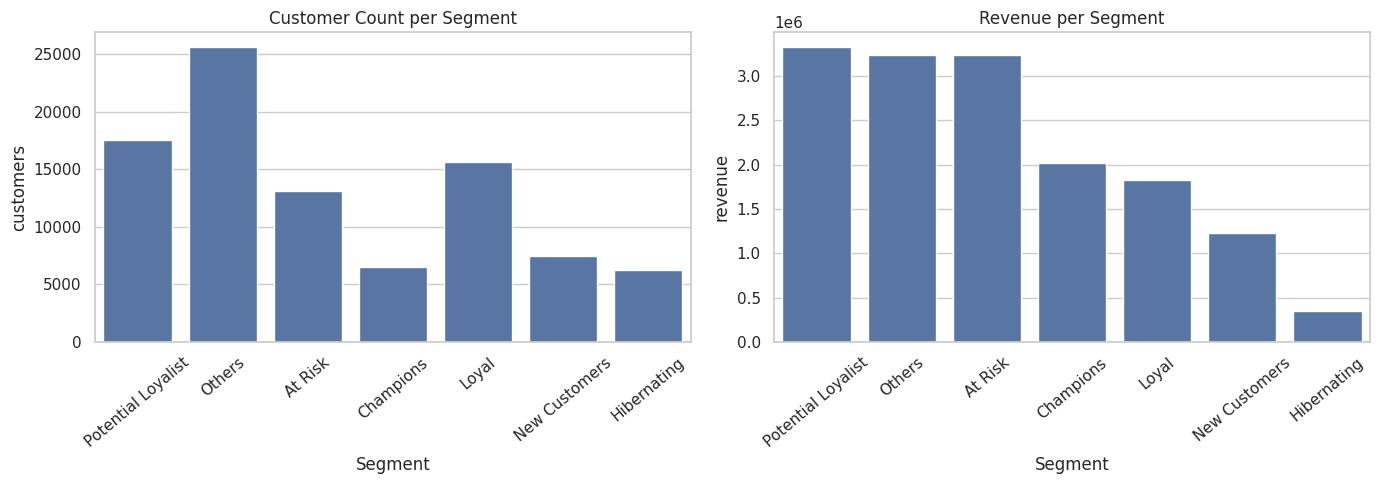

Recommended Plays
Champions           VIP perks, early access, premium bundles, refe...
Loyal               Points multiplier, cross-sell related categori...
Potential Loyalist  Welcome + first-purchase coupon, product educa...
At Risk             Win-back vouchers, CS outreach, free return in...
Hibernating         Re-activation campaigns, seasonal promos, push...
New Customers       Onboarding emails, repeat vouchers, product re...
Others              A/B test offers: discounts vs free shipping fo...

In [73]:
# ================================
# 6) Segment Summary
# ================================
seg_summary = (
    rfm.groupby("Segment")
    .agg(
        customers=("customer_unique_id", "count"),
        avg_R=("recency_days", "mean"),
        avg_F=("frequency", "mean"),
        avg_M=("monetary", "mean"),
        revenue=("monetary", "sum")
    )
    .sort_values("revenue", ascending=False)
)
seg_summary["revenue_share"] = seg_summary["revenue"] / seg_summary["revenue"].sum()
display(seg_summary)

# Plot Segments
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=seg_summary.reset_index(), x="Segment", y="customers", ax=ax[0])
ax[0].set_title("Customer Count per Segment"); ax[0].tick_params(axis="x", rotation=40)
sns.barplot(data=seg_summary.reset_index(), x="Segment", y="revenue", ax=ax[1])
ax[1].set_title("Revenue per Segment"); ax[1].tick_params(axis="x", rotation=40)
plt.tight_layout(); plt.show()

# Recommended actions per segment
segment_actions = {
    "Champions":           "VIP perks, early access, premium bundles, referral program.",
    "Loyal":               "Points multiplier, cross-sell related categories, subscriptions.",
    "Potential Loyalist":  "Welcome + first-purchase coupon, product education, bundling.",
    "At Risk":             "Win-back vouchers, CS outreach, free return incentives.",
    "Hibernating":         "Re-activation campaigns, seasonal promos, push notifications.",
    "New Customers":       "Onboarding emails, repeat vouchers, product recommendations.",
    "Others":              "A/B test offers: discounts vs free shipping for re-orders."
}
display(pd.DataFrame.from_dict(segment_actions, orient="index", columns=["Recommended Plays"]))

customers  recency_days  frequency  monetary      revenue  \
cluster                                                              
1            89302         223.0        1.0    105.38  14365529.86   
0             2745         203.0        2.0    225.51    846508.02   

         revenue_share  
cluster                 
1             0.944353  
0             0.055647

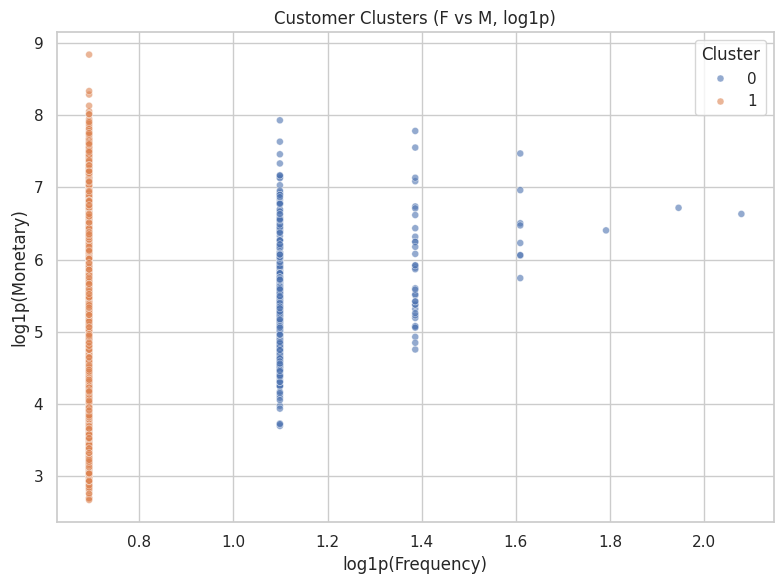

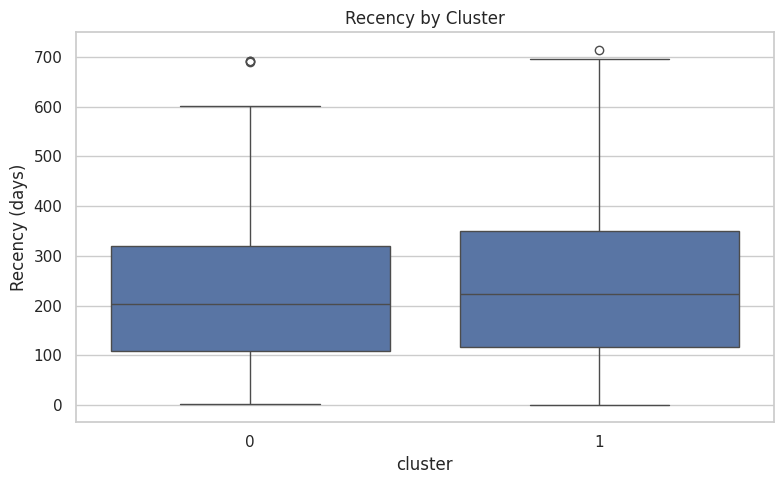

In [74]:
# ================================
# 7) Customer Clustering (K-Means)
# ================================
X = rfm[["recency_days", "frequency", "monetary"]].copy()
X["frequency_log1p"] = np.log1p(X["frequency"])
X["monetary_log1p"]  = np.log1p(X["monetary"])
X_clu = X[["recency_days", "frequency_log1p", "monetary_log1p"]]

Xz = StandardScaler().fit_transform(X_clu)

# Find best k
scores = [(k, silhouette_score(Xz, KMeans(n_clusters=k, n_init=20, random_state=42).fit_predict(Xz)))
          for k in range(2, 8)]
best_k = max(scores, key=lambda x: x[1])[0]

kmeans = KMeans(n_clusters=best_k, n_init=50, random_state=42)
rfm["cluster"] = kmeans.fit_predict(Xz)

# Cluster profile
cluster_profile = (
    rfm.groupby("cluster")
    .agg(
        customers=("customer_unique_id", "count"),
        recency_days=("recency_days", "median"),
        frequency=("frequency", "median"),
        monetary=("monetary", "median"),
        revenue=("monetary", "sum")
    )
    .sort_values("revenue", ascending=False)
)
cluster_profile["revenue_share"] = cluster_profile["revenue"] / cluster_profile["revenue"].sum()
display(cluster_profile)

# Plot clusters (F vs M)
plot_df = rfm.sample(min(15000, len(rfm)), random_state=42).copy()
plot_df["F_log1p"], plot_df["M_log1p"] = np.log1p(plot_df["frequency"]), np.log1p(plot_df["monetary"])

plt.figure(figsize=(8,6))
sns.scatterplot(data=plot_df, x="F_log1p", y="M_log1p", hue="cluster", alpha=0.6, s=25)
plt.title("Customer Clusters (F vs M, log1p)"); plt.xlabel("log1p(Frequency)"); plt.ylabel("log1p(Monetary)")
plt.legend(title="Cluster"); plt.tight_layout(); plt.show()

# Recency by Cluster
plt.figure(figsize=(8,5))
sns.boxplot(data=rfm, x="cluster", y="recency_days")
plt.title("Recency by Cluster"); plt.ylabel("Recency (days)")
plt.tight_layout(); plt.show()

In [75]:
# ================================
# 8) Cluster Personas
# ================================
def cluster_persona(row):
    r, f, m = row["recency_days"], row["frequency"], row["monetary"]
    med_r, med_f, med_m = rfm["recency_days"].median(), rfm["frequency"].median(), rfm["monetary"].median()
    if r < med_r and f > med_f and m > med_m: return "High-Value Active"
    if r < med_r and f <= med_f:              return "New/Active Low-F"
    if r >= med_r and f > med_f:              return "Seasonal Loyal"
    return "Dormant/Low-Value"

rfm["persona"] = rfm.apply(cluster_persona, axis=1)

persona_view = (
    rfm.groupby(["cluster", "persona"])
       .agg(customers=("customer_unique_id", "count"),
            revenue=("monetary", "sum"),
            avg_R=("recency_days", "mean"),
            avg_F=("frequency", "mean"),
            avg_M=("monetary", "mean"))
       .sort_values(["cluster", "revenue"], ascending=[True, False])
)
display(persona_view)

customers     revenue       avg_R     avg_F  \
cluster persona                                                          
0       High-Value Active       1340   458527.53  115.116418  2.159701   
        Seasonal Loyal          1241   374512.91  353.832393  2.078969   
        Dormant/Low-Value        164    13467.58  113.512195  2.006098   
1       New/Active Low-F       44425  7184534.23  114.209814  1.000000   
        Dormant/Low-Value      44877  7180995.63  366.353076  1.000000   

                                avg_M  
cluster persona                        
0       High-Value Active  342.184724  
        Seasonal Loyal     301.783167  
        Dormant/Low-Value   82.119390  
1       New/Active Low-F   161.722774  
        Dormant/Low-Value  160.015055

In [76]:
# ================================
# 9) Save outputs
# ================================
rfm_out = rfm[["customer_unique_id", "recency_days", "frequency", "monetary",
               "R_score", "F_score", "M_score", "RFM_sum", "Segment", "cluster", "persona"]]
rfm_out.to_csv("/content/rfm_segments.csv", index=False)
seg_summary.reset_index().to_csv("/content/segment_summary.csv", index=False)
cluster_profile.reset_index().to_csv("/content/cluster_profile.csv", index=False)

print("Saved CSVs: rfm_segments.csv, segment_summary.csv, cluster_profile.csv")

Saved CSVs: rfm_segments.csv, segment_summary.csv, cluster_profile.csv


# Forecasting

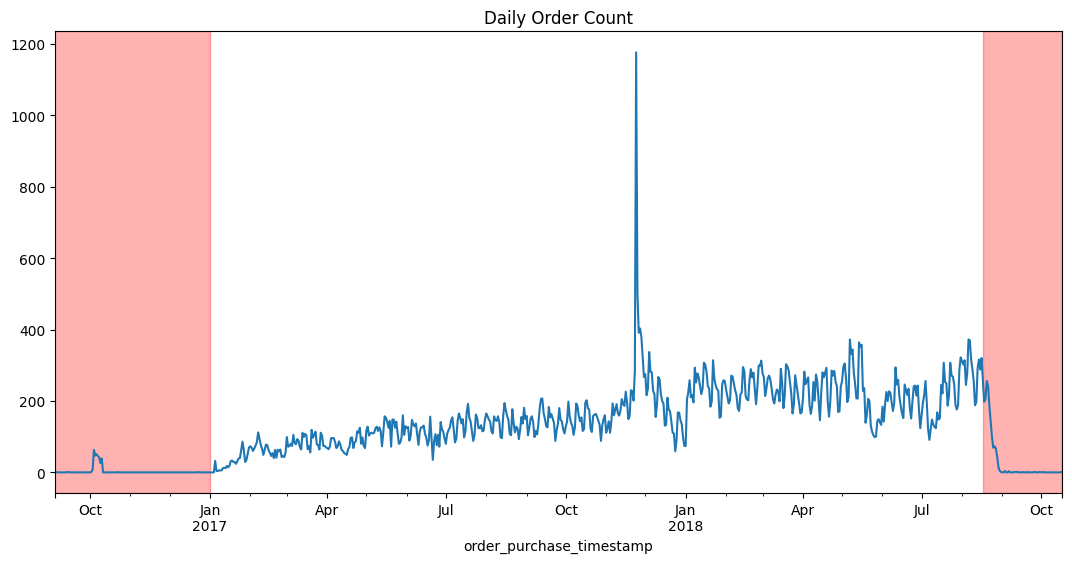

In [13]:
# =========================================
# Forecasting (Optimized, same methodology)
# =========================================

# ---------- Prep: daily series ----------
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
full_history = orders["order_purchase_timestamp"].dt.date

start, end = full_history.min(), full_history.max()
idx = pd.date_range(start, end, normalize=True)

full_history = (
    pd.Series(full_history)
    .value_counts(sort=False)
    .sort_index()
    .reindex(idx.date, fill_value=0)
)
full_history.index = pd.to_datetime(full_history.index)

fig, ax = plt.subplots(figsize=(13, 6))
full_history.plot(ax=ax)
ax.axvspan(datetime.date(2016, 9, 1), datetime.date(2017, 1, 1), color='red', alpha=0.3)
ax.axvspan(datetime.date(2018, 8, 17), datetime.date(2018, 10, 17), color='red', alpha=0.3)
ax.set_title('Daily Order Count')
plt.show()

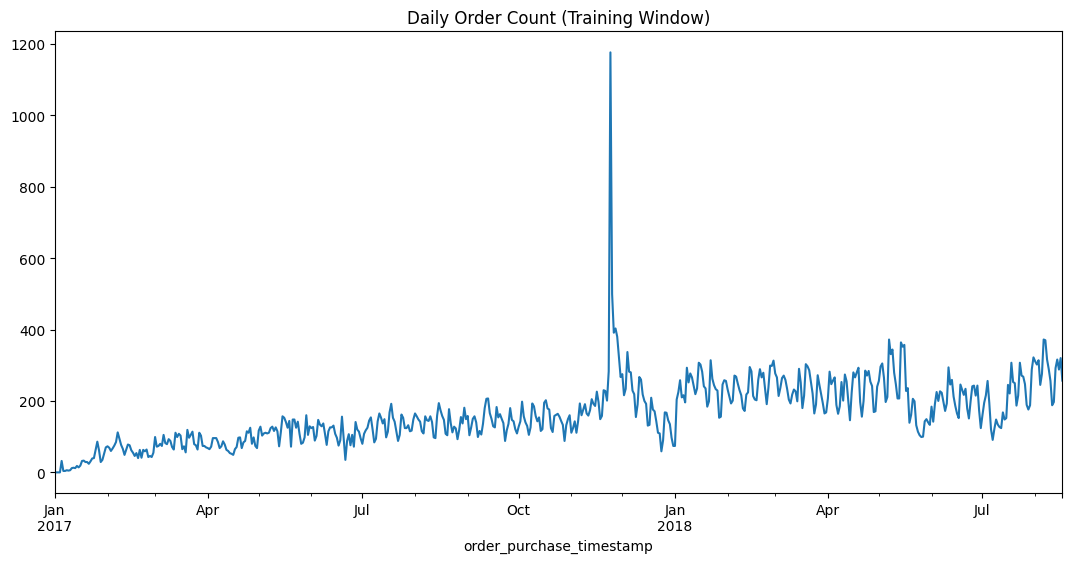

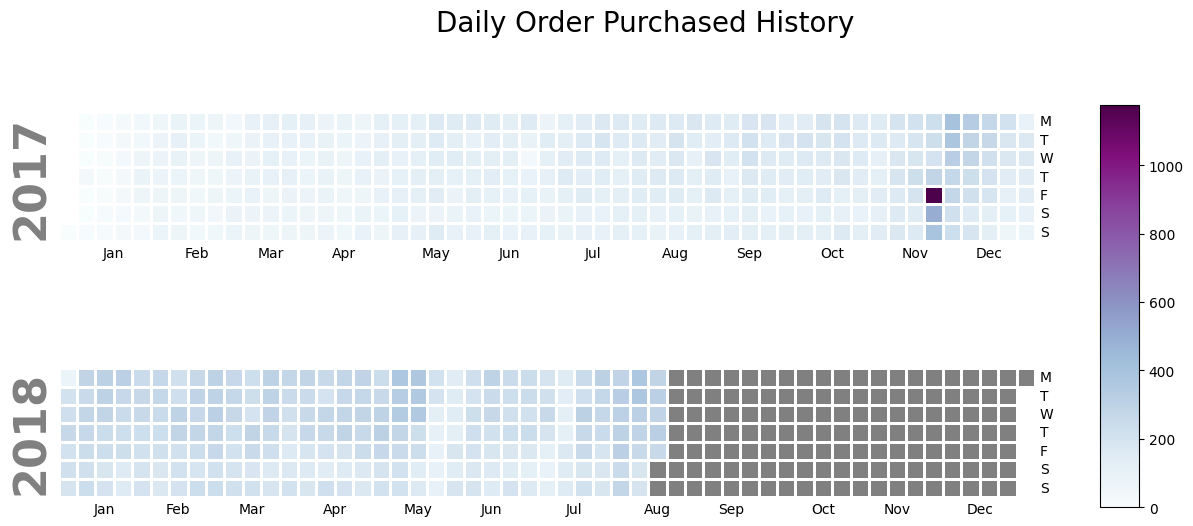

In [14]:
# ---------- Trim outliers & define horizon ----------
history     = full_history[datetime.date(2017, 1, 1): datetime.date(2018, 8, 17)]
pred_period = pd.date_range(datetime.date(2018, 8, 17), datetime.date(2018, 10, 17))

fig, ax = plt.subplots(figsize=(13, 6))
history.plot(ax=ax)
ax.set_title('Daily Order Count (Training Window)')
plt.show()

fig, caxs = calmap.calendarplot(history, daylabels='MTWTFSS', fillcolor='grey',
                                cmap='BuPu', fig_kws=dict(figsize=(13, 6)))
fig.suptitle('Daily Order Purchased History', fontsize=20)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.67])
fig.colorbar(caxs[0].get_children()[1], cax=cbar_ax)
plt.show()

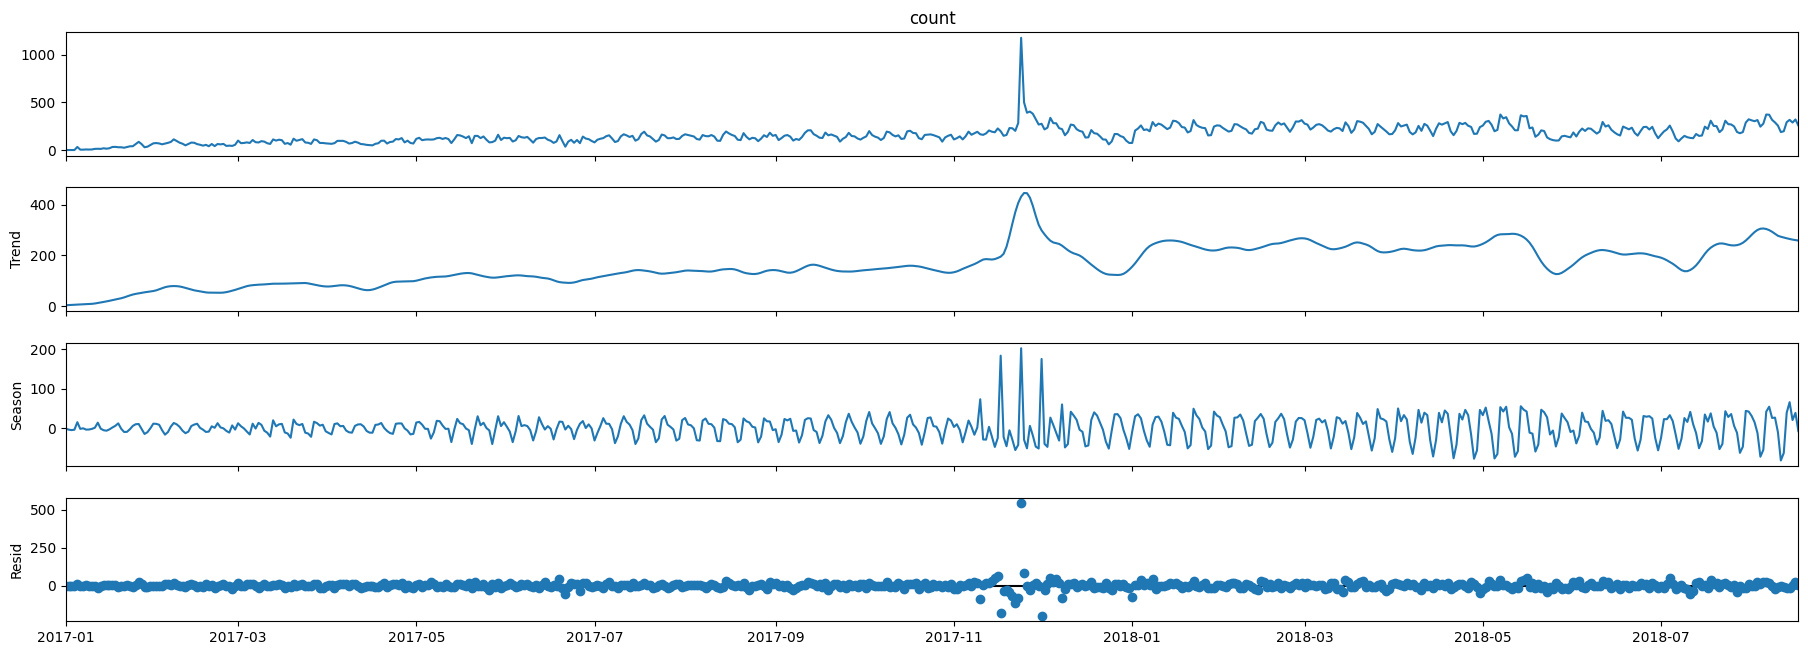

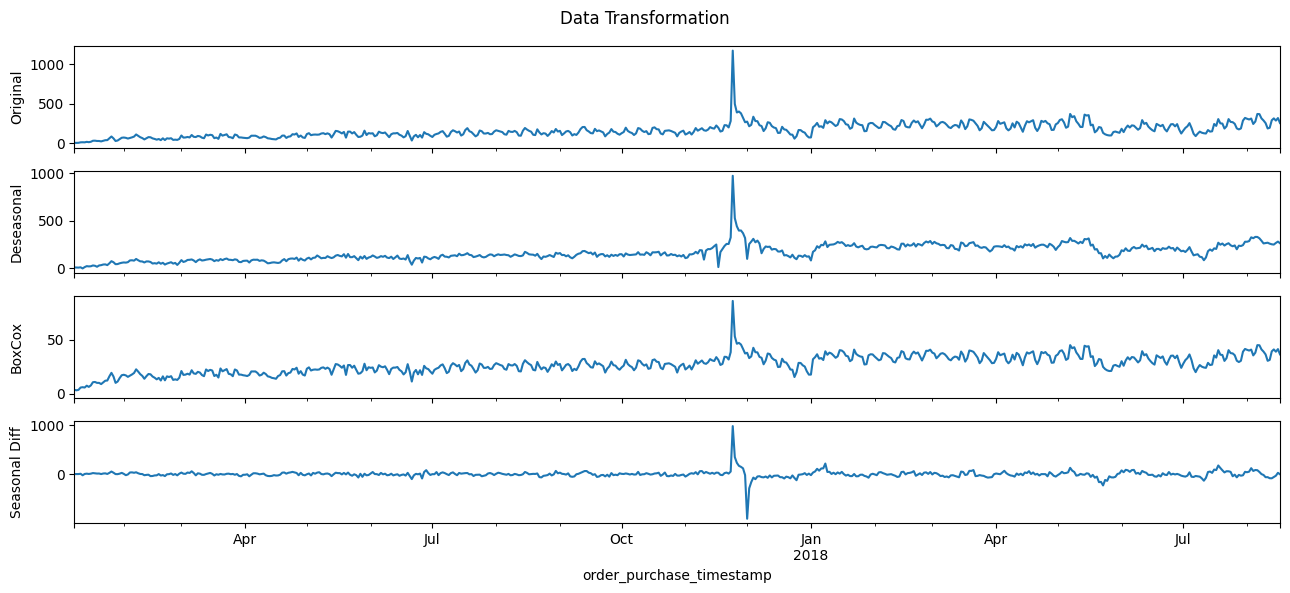

In [15]:
# ---------- Decomposition & transformations ----------
stl      = STL(history)
stl_res  = stl.fit()
deseasonal = stl_res.observed - stl_res.seasonal

fig = stl_res.plot(); fig.set_size_inches((20, 7)); plt.show()

# Box-Cox
bc_history, lmbda = boxcox(history + 1)
bc_history = pd.Series(bc_history, index=history.index)

# Seasonal differencing (7)
diff_history = history.diff(7).dropna()
xi = history.iloc[:7]

fig, axs = plt.subplots(nrows=4, sharex=True, figsize=(13, 6))
history.plot(ax=axs[0]);      axs[0].set_ylabel('Original')
deseasonal.plot(ax=axs[1]);   axs[1].set_ylabel('Deseasonal')
pd.Series(bc_history, index=history.index).plot(ax=axs[2]); axs[2].set_ylabel('BoxCox')
diff_history.plot(ax=axs[3]); axs[3].set_ylabel('Seasonal Diff')
fig.align_ylabels(); fig.suptitle('Data Transformation'); plt.tight_layout(); plt.show()

In [18]:
# ---------- Inverse seasonal differencing helper ----------
def diff_inv_fix(x_diff, xi, lags=7):
    """
    Invert seasonal differencing using seasonal template xi (length=lags).
    Ref: https://github.com/alkaline-ml/pmdarima/issues/410
    """
    total_len = len(x_diff) + len(xi)
    ix = pd.date_range(xi.index[0], periods=total_len)
    inv = diff_inv(x_diff, lags, xi=xi) + np.fromiter(cycle(xi), count=total_len, dtype=float)
    return pd.Series(inv, index=ix, name='order_purchase_timestamp')

# ---------- Stationarity checks (kept same) ----------
adf = ADFTest()
_ = adf.should_diff(history)
_ = adf.should_diff(diff_history)

kpss = KPSSTest()
_ = kpss.should_diff(history)
_ = kpss.should_diff(diff_history)

# ---------- CV splitter ----------
tscv = TimeSeriesSplit(max_train_size=pred_period.shape[0],
                       test_size=pred_period.shape[0])

In [19]:
# ---------- Result table & utilities ----------
result = pd.DataFrame(columns=['algo', 'mse'])

def record(algo, mse):
    new = pd.DataFrame(dict(algo=[algo], mse=[mse]))
    display(new)
    return new

def plot_cv_lastfold(index, pred, mse, title, fig=None, ax=None):
    """Unified plotting for last CV fold."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(13, 6))
        ax.set_title(title + ': Last Fold CV In-Sample Forecasting')
        show_now = True
    else:
        ax.set_title(title); show_now = False

    patch_ = mpatches.Patch(color='white', label=f'MSE: {np.mean(mse):.1e}')
    L1 = ax.legend(handles=[patch_], loc='upper left', fancybox=True, framealpha=0.7, handlelength=0)
    ax.add_artist(L1)
    sns.lineplot(x=history.index, y=history, label='true', ax=ax)
    sns.lineplot(x=index, y=pred, label='pred', ax=ax)
    ax.axvline(x=index[0], color='red'); ax.legend(loc='upper right')
    if show_now: plt.show()

In [20]:
# ======================================================================
# A) Linear Regression (Time-series regression) baselines + transforms
# ======================================================================

MAX_EPOCHS = 25
N_FEATURES = 7
SEED = 1234

def tsreg_eval(series, title, postprocess=None, adjust_target=None, ax=None):
    """Evaluate 'Time-Series Regression' with rolling one-step ahead inside fold."""
    mse = []
    y_pred = None; y_test = None
    for train_id, test_id in tscv.split(series):
        train, y_test = series.iloc[train_id], series.iloc[test_id]

        gen = TimeseriesGenerator(train, train, length=N_FEATURES, batch_size=1000)
        X_train, y_train = gen[0]
        lr = LinearRegression().fit(X_train, y_train)

        # rolling forecast on the fold
        X_roll = y_train[-N_FEATURES:].reshape(1, -1)
        y_pred = np.empty_like(y_test.values, dtype=float)
        for i in range(len(y_pred)):
            fc = lr.predict(X_roll)
            X_roll = np.concatenate((X_roll[:, 1:], fc.reshape(1, 1)), axis=1)
            y_pred[i] = fc

        # optional postprocess (e.g., add back seasonality, inverse boxcox, invert diff)
        y_p = y_pred.copy()
        y_t = y_test.copy()
        if adjust_target is not None:  # e.g., add back seasonal for target too
            y_t = adjust_target(y_t, train)

        if postprocess is not None:
            y_p = postprocess(y_p, train, y_test.index)

        mse.append(mean_squared_error(y_t, y_p))

    plot_cv_lastfold(y_test.index, y_p, mse, title, ax=ax)
    return np.mean(mse)

# Multi-panel figure for 4 variants
figs, axs = plt.subplots(nrows=4, sharex=True, figsize=(13, 6))
figs.suptitle('Last Fold CV In-Sample Forecasting'); figs.tight_layout(); plt.close(figs)

In [25]:
# 1) Raw
mse_tsreg = tsreg_eval(
    history,
    title='Time-Series Regression',
    ax=axs[0]
)
result = pd.concat([result, record('Time-Series Regression', mse_tsreg)], ignore_index=True)

# 2) + STL (add back last known seasonal)
def add_back_seasonal_pred(y_pred, train, idx):
    last_seasonal = stl_res.seasonal.reindex_like(train).tail(stl.period)
    return y_pred + np.fromiter(cycle(last_seasonal), count=y_pred.shape[0], dtype=float)

def add_back_seasonal_target(y_test_fold, train):
    return y_test_fold + stl_res.seasonal.reindex_like(y_test_fold)

mse_tsreg_stl = tsreg_eval(
    deseasonal,
    title='Time-Series Regression + STL',
    postprocess=add_back_seasonal_pred,
    adjust_target=add_back_seasonal_target,
    ax=axs[1]
)
result = pd.concat([result, record('Time-Series Regression + STL', mse_tsreg_stl)], ignore_index=True)

# 3) + BoxCox (inverse back)
def inv_boxcox_pred(y_pred, train, idx):
    return inv_boxcox1p(y_pred, lmbda)

def inv_boxcox_target(y_test_fold, train):
    return inv_boxcox1p(y_test_fold, lmbda)

mse_tsreg_bc = tsreg_eval(
    pd.Series(bc_history, index=history.index),
    title='Time-Series Regression + Boxcox',
    postprocess=inv_boxcox_pred,
    adjust_target=inv_boxcox_target,
    ax=axs[2]
)
result = pd.concat([result, record('Time-Series Regression + Boxcox', mse_tsreg_bc)], ignore_index=True)

# 4) + Seasonal Diff (invert)
def inv_seasonal_diff_pred(y_pred, train, idx):
    xi_local = history.reindex_like(train).tail(N_FEATURES)
    return diff_inv_fix(y_pred, xi_local).iloc[N_FEATURES:].reindex(idx)

def inv_seasonal_diff_target(y_test_fold, train):
    xi_local = history.reindex_like(train).tail(N_FEATURES)
    return diff_inv_fix(y_test_fold, xi_local).iloc[N_FEATURES:]

mse_tsreg_diff = tsreg_eval(
    diff_history,
    title='Time-Series Regression + Seasonal Diff',
    postprocess=inv_seasonal_diff_pred,
    adjust_target=inv_seasonal_diff_target,
    ax=axs[3]
)
result = pd.concat([result, record('Time-Series Regression + Seasonal Diff', mse_tsreg_diff)], ignore_index=True)

/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])
/tmp/ipython-input-529007490.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = fc
/tmp/ipython-input-529007490.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = fc
/tmp/ipython-input-529007490.py:26: DeprecationWarning: Conversion of an a

algo          mse
0  Time-Series Regression  8334.514194

/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])
/tmp/ipython-input-529007490.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = fc
/tmp/ipython-input-529007490.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = fc
/tmp/ipython-input-529007490.py:26: DeprecationWarning: Conversion of an a

algo         mse
0  Time-Series Regression + STL  8015.76522

/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])
/tmp/ipython-input-529007490.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = fc
/tmp/ipython-input-529007490.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = fc
/tmp/ipython-input-529007490.py:26: DeprecationWarning: Conversion of an a

algo          mse
0  Time-Series Regression + Boxcox  8361.963924

/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])
/tmp/ipython-input-529007490.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = fc
/tmp/ipython-input-529007490.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = fc
/tmp/ipython-input-529007490.py:26: DeprecationWarning: Conversion of an a

algo          mse
0  Time-Series Regression + Seasonal Diff  9664.568433

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

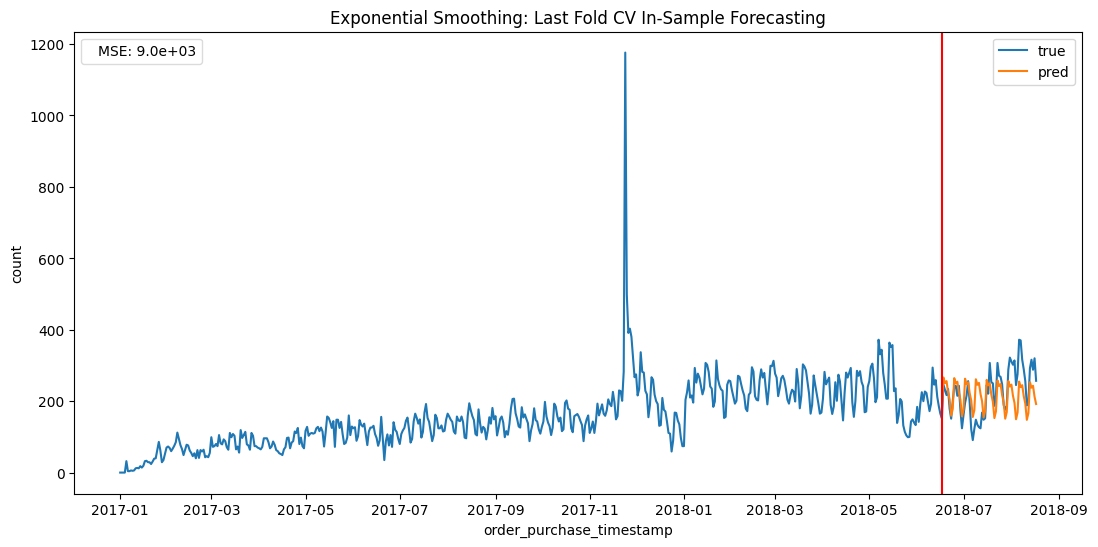

algo         mse
0  Exponential Smoothing  8986.67784

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

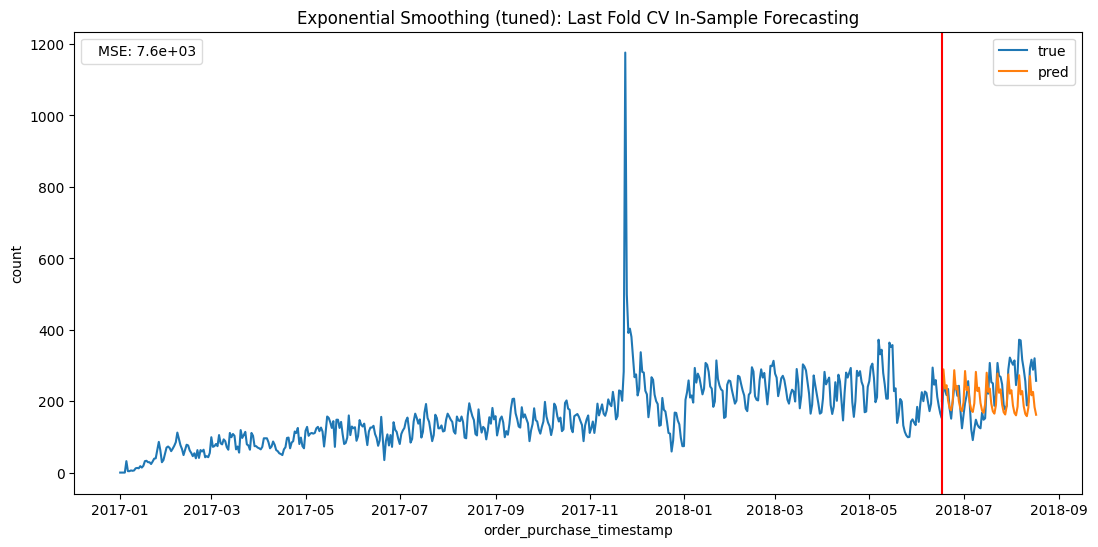

algo          mse
0  Exponential Smoothing (tuned)  7571.135916

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

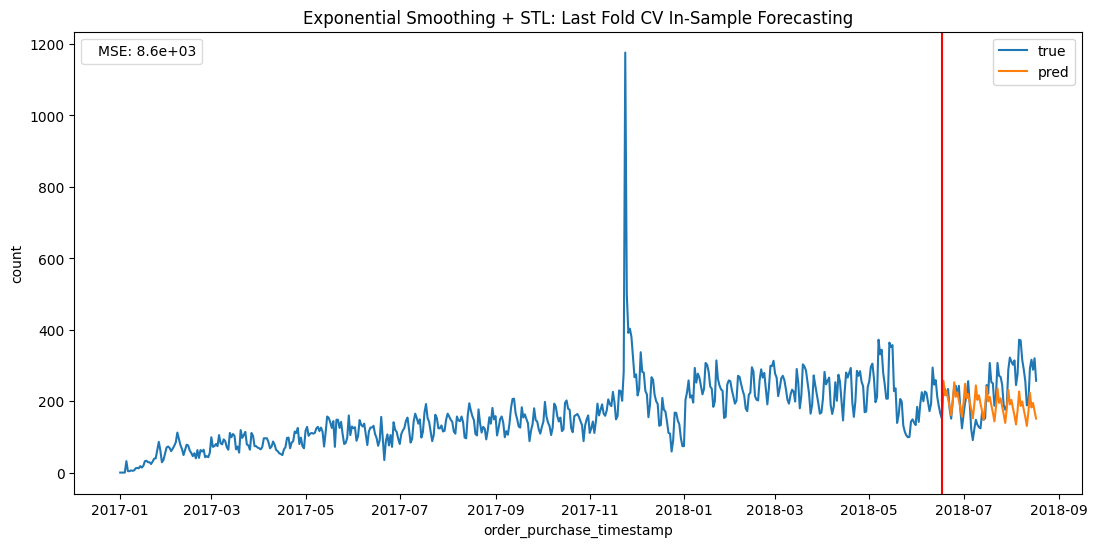

algo          mse
0  Exponential Smoothing + STL  8592.191762

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

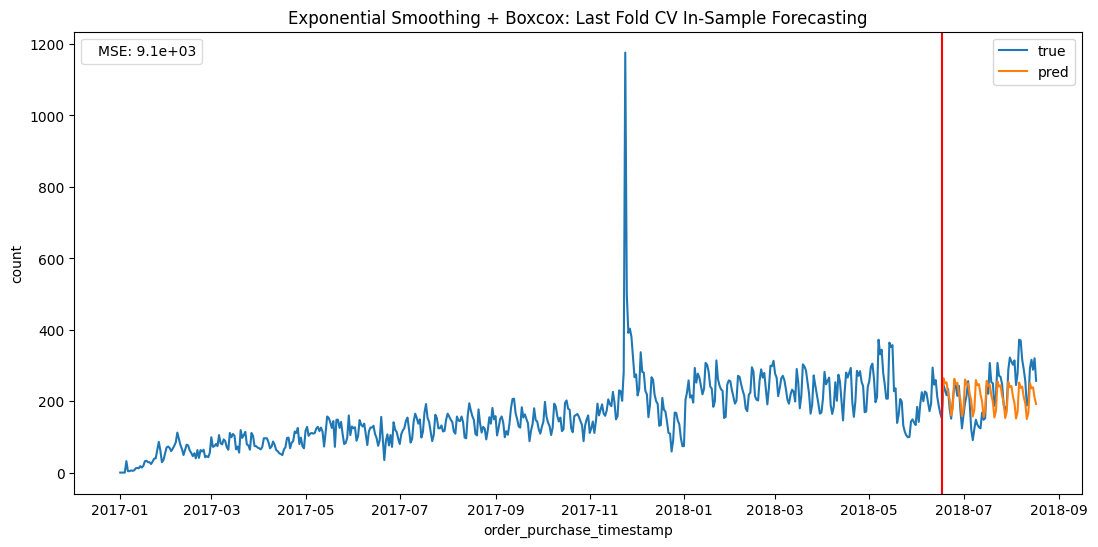

algo          mse
0  Exponential Smoothing + Boxcox  9108.856409

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

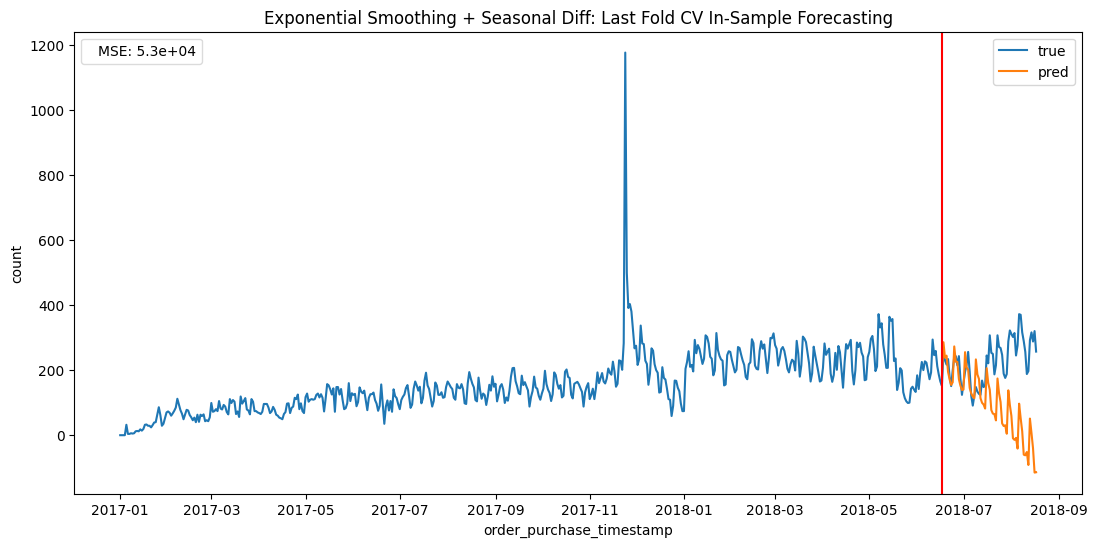

algo           mse
0  Exponential Smoothing + Seasonal Diff  52704.141157

In [26]:
# ======================================================================
# B) Exponential Smoothing (ES) + variants (+ tuning)
# ======================================================================

def es_eval(series, title, ax=None, seasonal_periods=7, fit_kwargs=None, postprocess=None, adjust_target=None):
    mse = []
    y_p = y_t = None
    fit_kwargs = fit_kwargs or dict(method='ls')
    for train_id, test_id in tscv.split(series):
        train, test = series.iloc[train_id], series.iloc[test_id]
        ES = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods).fit(**fit_kwargs)
        pred = ES.forecast(test.shape[0])

        if adjust_target is not None:
            test = adjust_target(test, train)
        if postprocess is not None:
            pred = postprocess(pred, train, test.index)

        mse.append(mean_squared_error(pred, test))
        y_p, y_t = pred, test

    plot_cv_lastfold(y_t.index, y_p, mse, title)
    return np.mean(mse)

# Baseline ES
mse_es = es_eval(history, 'Exponential Smoothing')
result = pd.concat([result, record('Exponential Smoothing', mse_es)], ignore_index=True)

# Grid search helper for ES
def es_gscv(series, alphas, betas, gammas, seasonal_periods=7, postprocess=None, adjust_target=None):
    def _gscv(alpha, beta, gamma):
        mses = []
        for train_id, test_id in tscv.split(series):
            train, test = series.iloc[train_id], series.iloc[test_id]
            ES = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods).fit(
                smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma, method='ls'
            )
            pred = ES.forecast(test.shape[0])
            if adjust_target is not None:
                test = adjust_target(test, train)
            if postprocess is not None:
                pred = postprocess(pred, train, test.index)
            mses.append(mean_squared_error(pred, test))
        return np.mean(mses)
    grid = pd.DataFrame(product(alphas, betas, gammas), columns=['alpha', 'beta', 'gamma'])
    grid['mse'] = grid.apply(lambda x: _gscv(x.alpha, x.beta, x.gamma), axis=1)
    return grid

# ES tuned (example params keep same final pick)
alphas = betas = gammas = np.arange(0.0, 1.0, 0.1)
# (opsional) tuning_es = es_gscv(history, alphas, betas, gammas)
mse_es_tuned = es_eval(
    history, 'Exponential Smoothing (tuned)',
    fit_kwargs=dict(smoothing_level=0.2, smoothing_trend=0.0, smoothing_seasonal=0.8, method='ls')
)
result = pd.concat([result, record('Exponential Smoothing (tuned)', mse_es_tuned)], ignore_index=True)

# ES + STLForecast
def add_back_seasonal_pred_series(pred, train, idx):
    last_seasonal = stl_res.seasonal.reindex_like(train).tail(stl.period)
    return pred + np.fromiter(cycle(last_seasonal), count=len(pred), dtype=float)

def add_back_seasonal_target_series(test, train):
    return test + stl_res.seasonal.reindex_like(test)

def stlf_eval(series, title):
    mse = []
    y_p = y_t = None
    model_cls = ExponentialSmoothing
    model_kwargs = dict(trend='add', seasonal='add', seasonal_periods=7)
    fit_kwargs = dict(method='ls')
    for train_id, test_id in tscv.split(series):
        train, test = series.iloc[train_id], series.iloc[test_id]
        stlf = STLForecast(train, model_cls, model_kwargs=model_kwargs).fit(fit_kwargs=fit_kwargs)
        pred = stlf.forecast(test.shape[0])
        mse.append(mean_squared_error(pred, test))
        y_p, y_t = pred, test
    plot_cv_lastfold(y_t.index, y_p, mse, title)
    return np.mean(mse)

mse_stlf = stlf_eval(history, 'Exponential Smoothing + STL')
result = pd.concat([result, record('Exponential Smoothing + STL', mse_stlf)], ignore_index=True)

# ES + BoxCox
def inv_boxcox_series(pred, train, idx):
    return inv_boxcox1p(pred, lmbda)

def inv_boxcox_target_series(test, train):
    return inv_boxcox1p(test, lmbda)

mse_es_bc = es_eval(
    pd.Series(bc_history, index=history.index),
    'Exponential Smoothing + Boxcox',
    postprocess=inv_boxcox_series,
    adjust_target=inv_boxcox_target_series
)
result = pd.concat([result, record('Exponential Smoothing + Boxcox', mse_es_bc)], ignore_index=True)

# ES + Seasonal Diff
def inv_diff_series(pred, train, idx):
    xi_local = history.reindex_like(train).tail(N_FEATURES)
    return diff_inv_fix(pred, xi_local).iloc[N_FEATURES:].reindex(idx)

def inv_diff_target_series(test, train):
    xi_local = history.reindex_like(train).tail(N_FEATURES)
    return diff_inv_fix(test, xi_local).iloc[N_FEATURES:]

mse_es_diff = es_eval(
    diff_history, 'Exponential Smoothing + Seasonal Diff',
    postprocess=inv_diff_series, adjust_target=inv_diff_target_series
)
result = pd.concat([result, record('Exponential Smoothing + Seasonal Diff', mse_es_diff)], ignore_index=True)

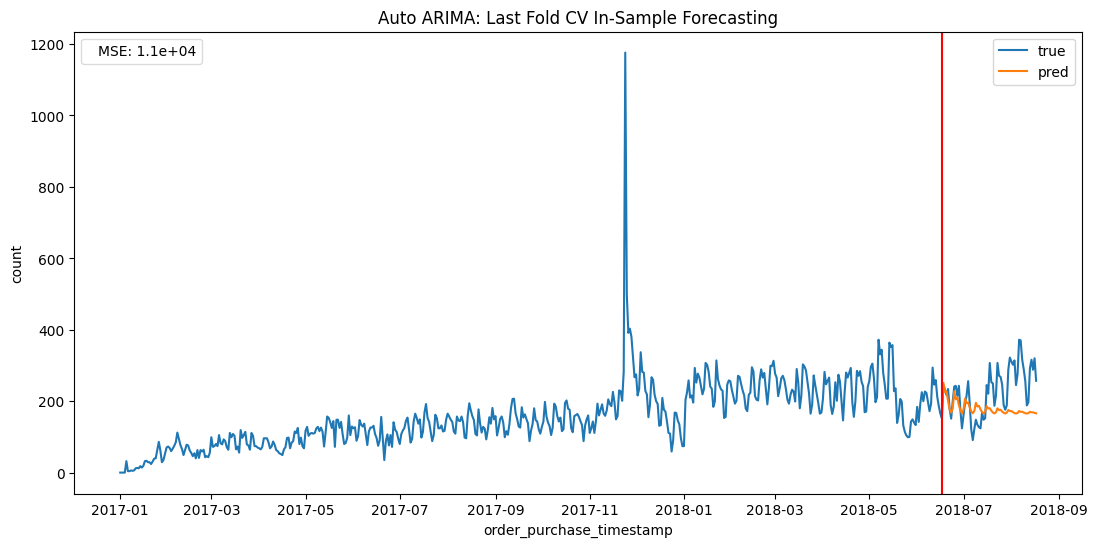

algo          mse
0  Auto ARIMA  10557.63486

/usr/local/lib/python3.12/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.12/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.12/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.12/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.12/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" 

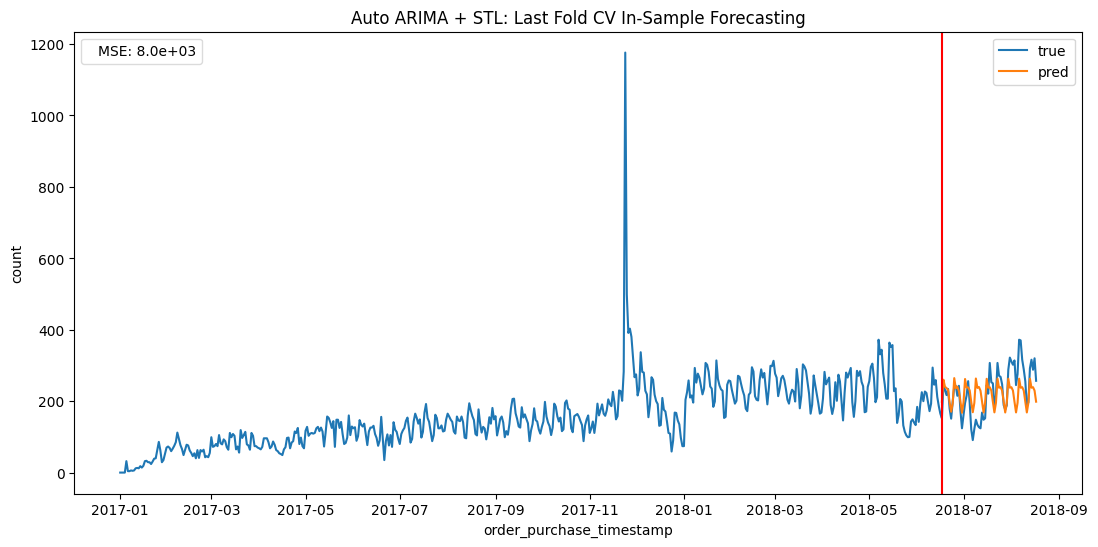

algo          mse
0  Auto ARIMA + STL  8032.572045

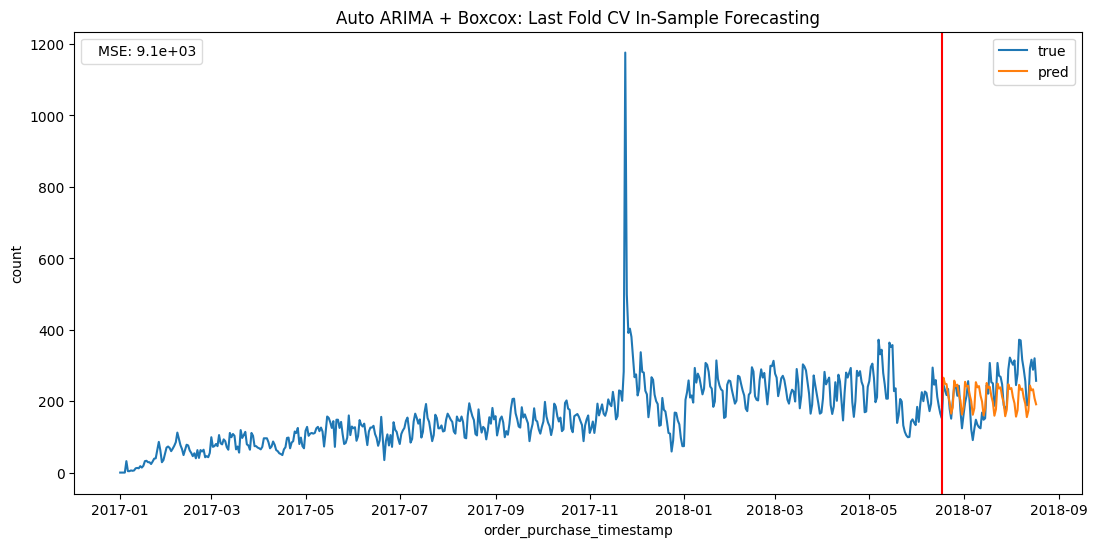

algo          mse
0  Auto ARIMA + Boxcox  9104.337473

/usr/local/lib/python3.12/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.12/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.12/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.12/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.12/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" 

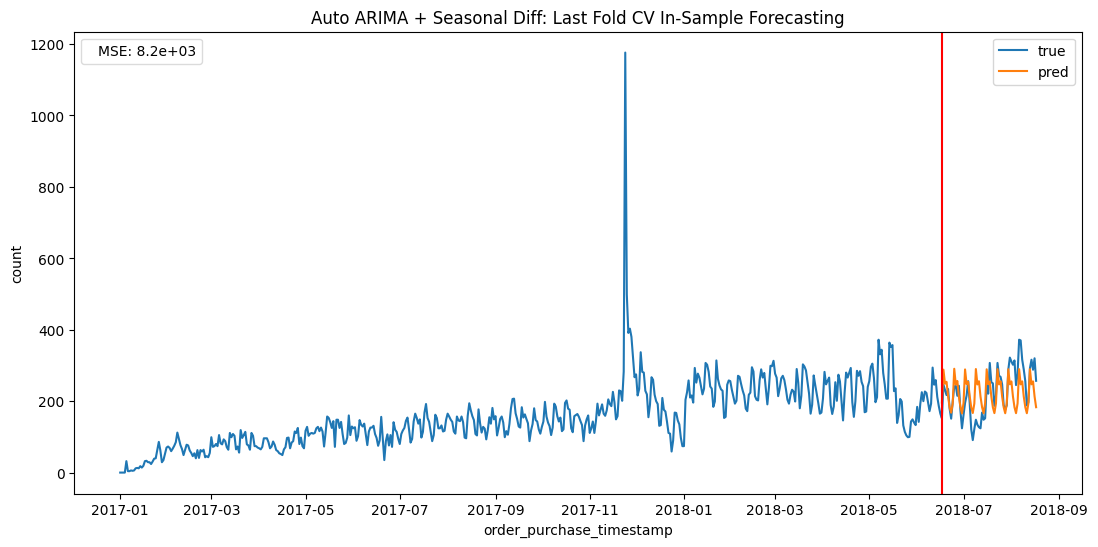

algo          mse
0  Auto ARIMA + Seasonal Diff  8185.451313

In [27]:
# ======================================================================
# C) Auto-ARIMA + variants
# ======================================================================

def arima_eval(series, title, seasonal_m=7, seasonal_flag=True, postprocess=None, adjust_target=None, ax=None):
    mse = []
    y_p = y_t = None
    for train_id, test_id in tscv.split(series):
        train, test = series.iloc[train_id], series.iloc[test_id]
        aa = auto_arima(train, m=seasonal_m, seasonal=seasonal_flag)
        pred = aa.predict(test.shape[0])

        if adjust_target is not None:
            test = adjust_target(test, train)
        if postprocess is not None:
            pred = postprocess(pred, train, test.index)

        mse.append(mean_squared_error(pred, test))
        y_p, y_t = pred, test

    plot_cv_lastfold(y_t.index, y_p, mse, title)
    return np.mean(mse)

# ARIMA base
mse_arima = arima_eval(history, 'Auto ARIMA', seasonal_m=7, seasonal_flag=True)
result = pd.concat([result, record('Auto ARIMA', mse_arima)], ignore_index=True)

# ARIMA + STL (no seasonal in ARIMA; add seasonal back)
mse_arima_stl = arima_eval(
    deseasonal, 'Auto ARIMA + STL',
    seasonal_flag=False,
    postprocess=add_back_seasonal_pred_series,
    adjust_target=add_back_seasonal_target_series
)
result = pd.concat([result, record('Auto ARIMA + STL', mse_arima_stl)], ignore_index=True)

# ARIMA + BoxCox
mse_arima_bc = arima_eval(
    pd.Series(bc_history, index=history.index), 'Auto ARIMA + Boxcox',
    seasonal_m=7, seasonal_flag=True,
    postprocess=inv_boxcox_series, adjust_target=inv_boxcox_target_series
)
result = pd.concat([result, record('Auto ARIMA + Boxcox', mse_arima_bc)], ignore_index=True)

# ARIMA + Seasonal Diff
mse_arima_diff = arima_eval(
    diff_history, 'Auto ARIMA + Seasonal Diff',
    seasonal_flag=False,
    postprocess=inv_diff_series, adjust_target=inv_diff_target_series
)
result = pd.concat([result, record('Auto ARIMA + Seasonal Diff', mse_arima_diff)], ignore_index=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/tmp/ipython-input-4092597862.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[i] = p
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:19

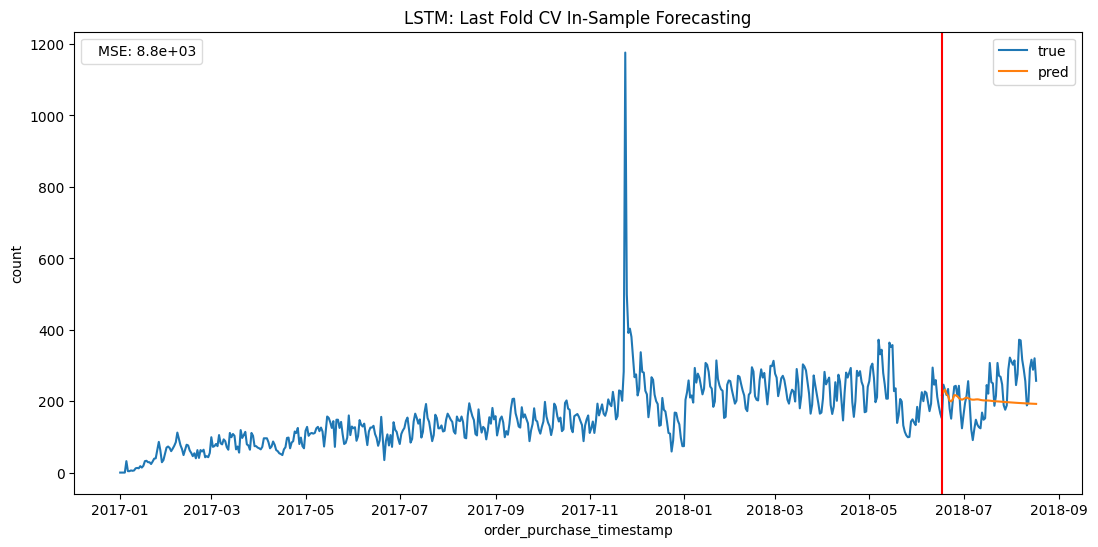

algo          mse
0  LSTM  8758.981611

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/tmp/ipython-input-4092597862.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[i] = p
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:19

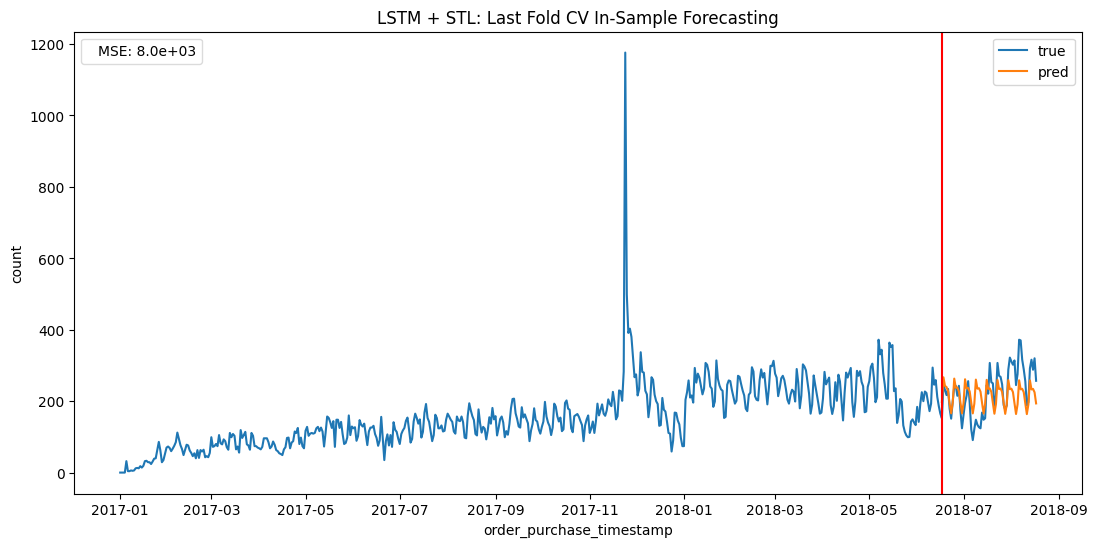

algo          mse
0  LSTM + STL  8000.004588

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/tmp/ipython-input-4092597862.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[i] = p
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:19

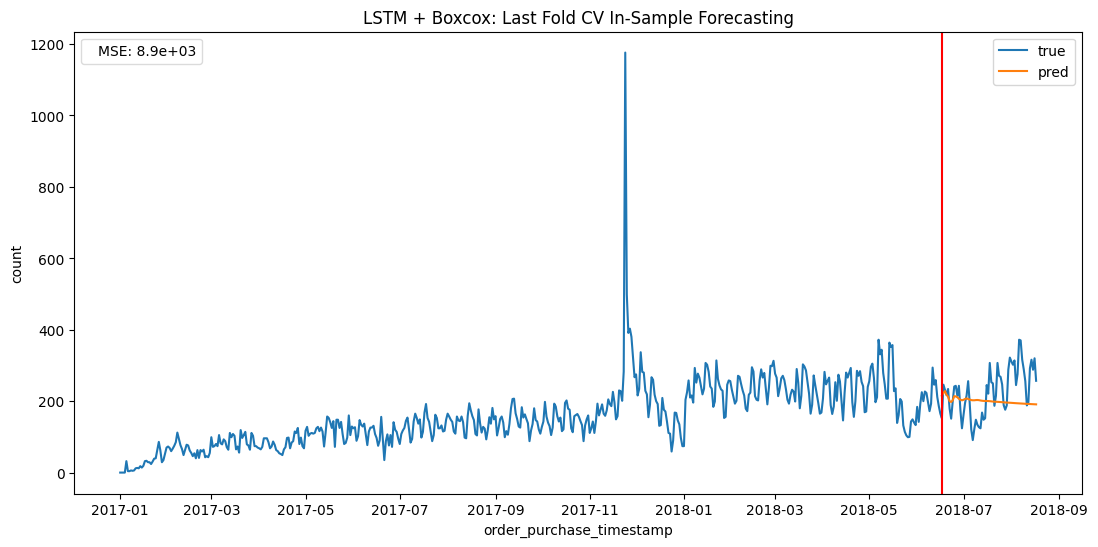

algo          mse
0  LSTM + Boxcox  8895.359168

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/tmp/ipython-input-4092597862.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[i] = p
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:19

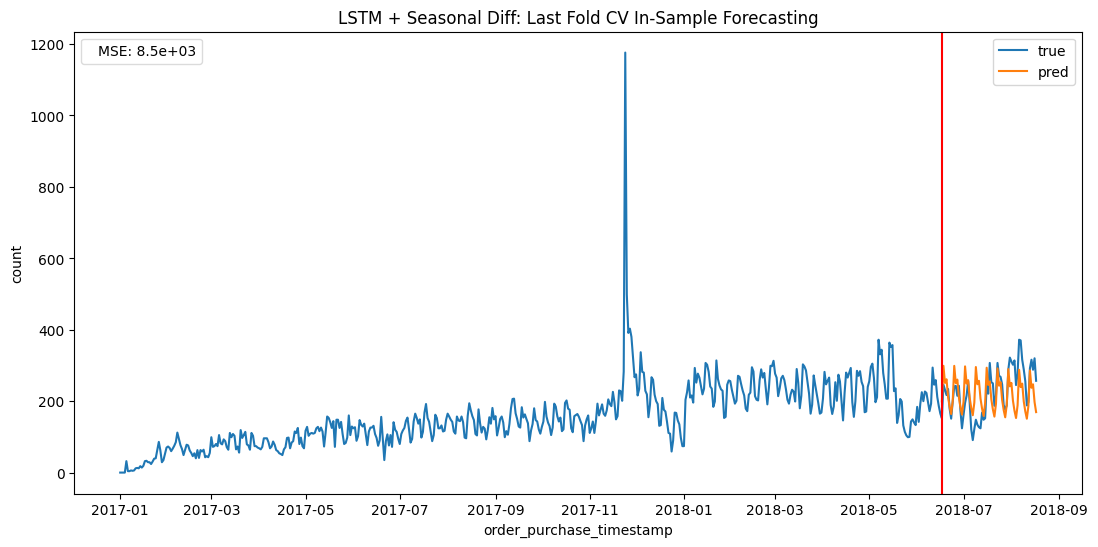

algo          mse
0  LSTM + Seasonal Diff  8474.840709

In [28]:
# ======================================================================
# D) LSTM + variants (+ learning-rate tuning)
# ======================================================================

def reset_random_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def lstm_eval(series, title, lr=0.001, postprocess=None, adjust_target=None, ax=None):
    mse = []
    y_p = y_t = None
    for train_id, test_id in tscv.split(series):
        train, test = series.iloc[train_id], series.iloc[test_id]

        ss = StandardScaler().fit(train.values.reshape(-1, 1))
        train_input = ss.transform(train.values.reshape(-1, 1))

        # bootstrap first window from train tail
        test_input = train_input[-(N_FEATURES + 1):]
        test_gen   = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
        train_gen  = TimeseriesGenerator(train_input, train_input, length=N_FEATURES, batch_size=30)

        clear_session(); reset_random_seeds()
        model = Sequential([LSTM(32, input_shape=(N_FEATURES, 1), return_sequences=False),
                            Dense(1, kernel_initializer='zeros')])
        early_stopping = EarlyStopping(monitor='loss', patience=2, mode='min')
        model.compile(loss='mse', optimizer=Adam(learning_rate=lr), metrics=['mae'])
        h = model.fit(train_gen, epochs=MAX_EPOCHS, callbacks=[early_stopping], verbose=False)

        pred = np.empty(test.shape[0])
        for i in range(len(pred)):
            p = model.predict(test_gen, verbose=False)
            pred[i] = p
            test_input = np.vstack([test_input[1:], p.reshape(1, 1)])
            test_gen   = TimeseriesGenerator(test_input, test_input, length=N_FEATURES, batch_size=30)
        pred = ss.inverse_transform(pred.reshape(-1, 1)).ravel()

        if adjust_target is not None:
            test = adjust_target(test, train)
        if postprocess is not None:
            pred = postprocess(pred, train, test.index)

        mse.append(mean_squared_error(pred, test))
        y_p, y_t = pred, test

    plot_cv_lastfold(y_t.index, y_p, mse, title)
    return np.mean(mse)

# LSTM base
mse_lstm = lstm_eval(history, 'LSTM', lr=0.001)
result = pd.concat([result, record('LSTM', mse_lstm)], ignore_index=True)

# Tuning helper (learning rate)
def lstm_tune_lr(series, lrs, postprocess=None, adjust_target=None):
    rows = []
    for lr in lrs:
        m = lstm_eval(series, f'LSTM(lr={lr})', lr=lr, postprocess=postprocess, adjust_target=adjust_target)
        rows.append(dict(learning_rate=lr, mse=m))
    df = pd.DataFrame(rows)
    ax = df.plot(x='learning_rate', y='mse', figsize=(13, 6), logx=True, title='Learning Rates implication on MSE')
    plt.show()
    return df

# (opsional) tuning_lr = lstm_tune_lr(history, np.logspace(-3, 1, 5))

# LSTM + STL
mse_lstm_stl = lstm_eval(
    deseasonal, 'LSTM + STL', lr=0.001,
    postprocess=add_back_seasonal_pred_series, adjust_target=add_back_seasonal_target_series
)
result = pd.concat([result, record('LSTM + STL', mse_lstm_stl)], ignore_index=True)

# LSTM + BoxCox
mse_lstm_bc = lstm_eval(
    pd.Series(bc_history, index=history.index), 'LSTM + Boxcox', lr=0.001,
    postprocess=inv_boxcox_pred, adjust_target=inv_boxcox_target
)
result = pd.concat([result, record('LSTM + Boxcox', mse_lstm_bc)], ignore_index=True)

# LSTM + Seasonal Diff
mse_lstm_diff = lstm_eval(
    diff_history, 'LSTM + Seasonal Diff', lr=0.001,
    postprocess=inv_seasonal_diff_pred, adjust_target=inv_seasonal_diff_target
)
result = pd.concat([result, record('LSTM + Seasonal Diff', mse_lstm_diff)], ignore_index=True)


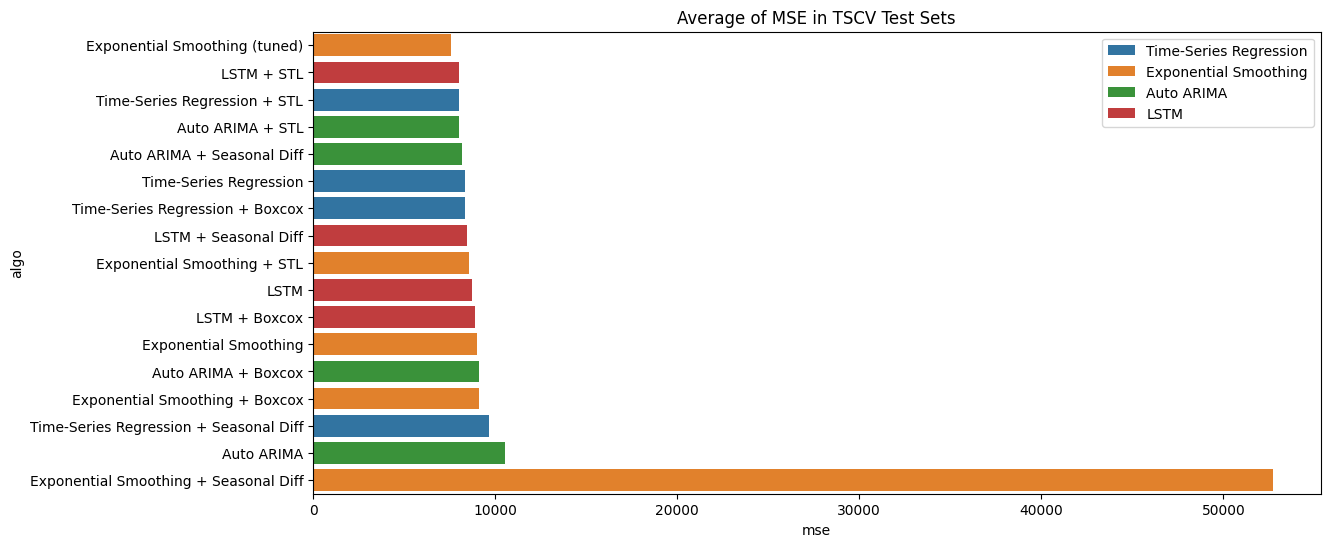

In [32]:
# ======================================================================
# E) Compare results & final ES out-of-sample forecast (same concept)
# ======================================================================
# normalize family names for hue
families = ['Time-Series Regression', 'Exponential Smoothing', 'Auto ARIMA', 'LSTM']

result = (
    result
    .assign(
        cat=lambda d: d['algo']
            .str.replace(r'\s*\+.*$', '', regex=True)      # remove " + XXX"
            .str.replace(r'\s*\(tuned\)$', '', regex=True) # remove "(tuned)"
    )
)
result['cat'] = np.where(result['cat'].isin(families), result['cat'], 'Other')

# use hue_order that exists in the data
hue_order = families + (['Other'] if 'Other' in result['cat'].unique() else [])

fig, ax = plt.subplots(figsize=(13, 6))
sns.barplot(
    data=result.sort_values('mse'),
    x='mse', y='algo',
    hue='cat', hue_order=hue_order,
    orient='h', dodge=False, ax=ax
)
ax.set_title('Average of MSE in TSCV Test Sets')
ax.legend().set_title(None)
plt.show()

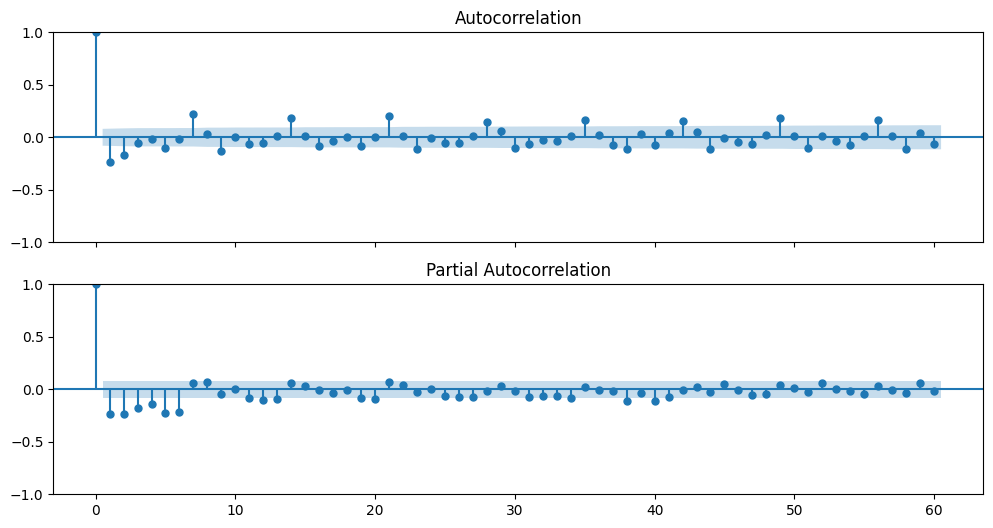

In [30]:
# ACF/PACF (unchanged)
fig, ax = plt.subplots(2, figsize=(12, 6), sharex=True)
plot_acf(history.diff().dropna(), ax=ax[0], lags=60)
plot_pacf(history.diff().dropna(), ax=ax[1], lags=60)
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


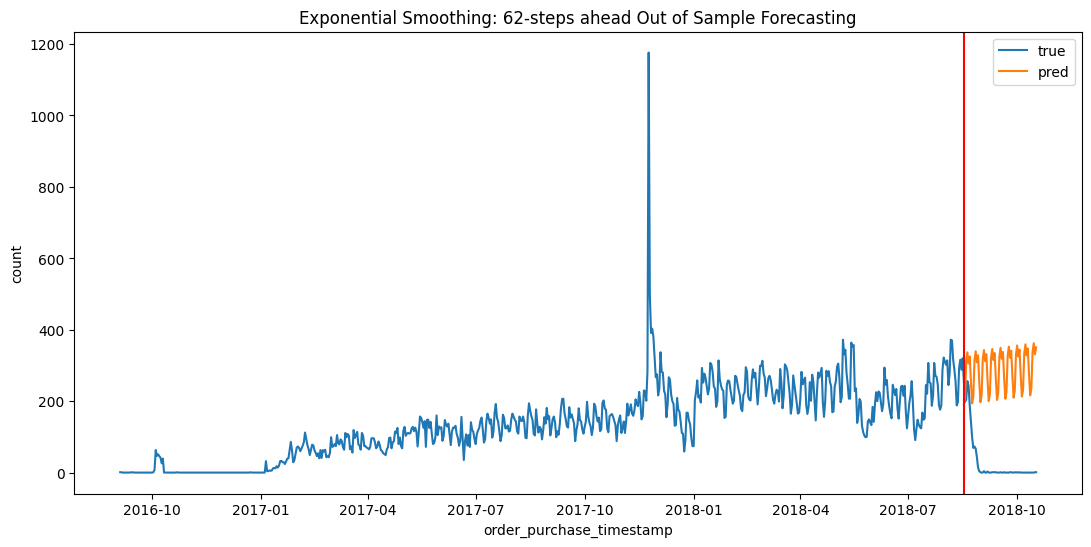

In [31]:
# Final: ES tuned (same params) → out-of-sample
ES_final = (
    ExponentialSmoothing(history, trend='add', seasonal='add', seasonal_periods=7)
    .fit(smoothing_level=0.2, smoothing_trend=0.0, smoothing_seasonal=0.8, method='ls')
)
pred = ES_final.forecast(pred_period.shape[0])

fig, ax = plt.subplots(figsize=(13, 6))
sns.lineplot(x=full_history.index, y=full_history, label='true')
sns.lineplot(x=pred_period, y=pred, label='pred')
ax.axvline(x=pred_period[0], color='red')
ax.set_title('Exponential Smoothing: 62-steps ahead Out of Sample Forecasting')
plt.show()